In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
)
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import pickle
import shap
import os
from datetime import datetime
import sys
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

# plt.rcParams['font.family'] ='Malgun Gothic' # 윈도우
plt.rcParams['font.family'] ='AppleGothic' # 맥
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

class SewagePredictionPipeline:
    def __init__(self, data_path_template='../data/add_feature/{}_add_feature.csv'):
        """
        하수처리량 예측 모델링 파이프라인
        
        Parameters:
        -----------
        data_path_template : str
            데이터 파일 경로 템플릿 (센터명이 들어갈 부분은 {}로 표시)
        """
        self.data_path_template = data_path_template
        self.centers = ['nanji', 'jungnang', 'seonam', 'tancheon']  # 실제 센터명으로 수정 필요
        
        # 제외할 컬럼 정의
        self.not_use_col = [
            '날짜',
            '1처리장','2처리장','정화조','중계펌프장','합계','시설현대화',
            '3처리장','4처리장','합계', '합계_1일후','합계_2일후',
            '등급','등급_1일후','등급_2일후'
        ]
        
        # 회귀 모델 정의
        self.regression_models = {
            'LinearRegression': LinearRegression(),
            'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100),
            'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
            'CatBoost': cb.CatBoostRegressor(random_state=42, verbose=False),
            'GradientBoost': GradientBoostingRegressor(random_state=42),
            'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
        }
        
        # 분류 모델 정의
        self.classification_models = {
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
            'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=False),
            'GradientBoost': GradientBoostingClassifier(random_state=42),
            'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
        }
        
        # 결과 저장용
        self.results = []
        self.best_models = {}
        
    def load_data(self, center):
        """센터별 데이터 로드"""
        file_path = self.data_path_template.format(center)
        try:
            data = pd.read_csv(file_path)
            print(f"{center} 센터 데이터 로드 완료: {data.shape}")
            return data
        except FileNotFoundError:
            print(f"파일을 찾을 수 없습니다: {file_path}")
            return None
    
    def prepare_features(self, data):
        """피처 및 타겟 준비"""
        # 사용할 컬럼 선별
        available_cols = [col for col in data.columns if col not in self.not_use_col]
        X = data[available_cols]
        
        # 타겟 변수
        y_reg = data['합계_1일후']  # 회귀용
        y_clf = data['등급_1일후']  # 분류용
        
        return X, y_reg, y_clf
    
    def split_data_temporal(self, X, y, test_size=0.2):
        """시계열 정보를 유지한 분할"""
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        return X_train, X_test, y_train, y_test
    
    def split_data_random(self, X, y, test_size=0.2, stratify=None):
        """랜덤 분할 (분류시 stratified)"""
        return train_test_split(X, y, test_size=test_size, 
                              stratify=stratify, random_state=42)
    
    def evaluate_regression(self, y_true, y_pred):
        """회귀 모델 평가 지표 계산"""
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        
        # MAPE 계산 (0으로 나누기 방지)
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else np.inf
        
        r2 = r2_score(y_true, y_pred)
        
        return {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2
        }
    
    def evaluate_classification(self, y_true, y_pred, y_pred_proba=None):
        """분류 모델 평가 지표 계산"""
        accuracy = accuracy_score(y_true, y_pred)
        precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        metrics = {
            'Accuracy': accuracy,
            'Precision_weighted': precision_weighted,
            'Precision_macro': precision_macro,
            'Recall_weighted': recall_weighted,
            'Recall_macro': recall_macro,
            'F1_weighted': f1_weighted,
            'F1_macro': f1_macro
        }
        
        # ROC AUC (다중분류의 경우 ovr 방식 사용)
        if y_pred_proba is not None:
            try:
                if len(np.unique(y_true)) == 2:
                    auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])
                else:
                    auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
                metrics['AUC'] = auc_score
            except:
                metrics['AUC'] = 0
        
        return metrics
    
    def train_and_evaluate_models(self, center):
        """센터별 모든 모델 학습 및 평가"""
        print(f"\n{'='*50}")
        print(f"{center.upper()} 센터 모델 학습 시작")
        print(f"{'='*50}")
        
        # 데이터 로드
        data = self.load_data(center)
        if data is None:
            return
        
        # 피처 준비
        X, y_reg, y_clf = self.prepare_features(data)
        
        print(f"피처 수: {X.shape[1]}")
        print(f"데이터 수: {X.shape[0]}")
        print(f"분류 타겟 클래스: {sorted(y_clf.unique())}")
        
        # 두 가지 분할 방법으로 모델 학습
        split_methods = ['temporal', 'random']
        
        for split_method in split_methods:
            print(f"\n--- {split_method.upper()} 분할 방법 ---")
            
            # 데이터 분할
            if split_method == 'temporal':
                X_train_reg, X_test_reg, y_train_reg, y_test_reg = self.split_data_temporal(X, y_reg)
                X_train_clf, X_test_clf, y_train_clf, y_test_clf = self.split_data_temporal(X, y_clf)
            else:
                X_train_reg, X_test_reg, y_train_reg, y_test_reg = self.split_data_random(X, y_reg)
                X_train_clf, X_test_clf, y_train_clf, y_test_clf = self.split_data_random(X, y_clf, stratify=y_clf)
            
            # 회귀 모델 학습
            print(f"\n회귀 모델 학습 ({split_method}):")
            for model_name, model in self.regression_models.items():
                try:
                    model.fit(X_train_reg, y_train_reg)
                    y_pred = model.predict(X_test_reg)
                    metrics = self.evaluate_regression(y_test_reg, y_pred)
                    
                    result = {
                        'center': center,
                        'split_method': split_method,
                        'task': 'regression',
                        'model': model_name,
                        **metrics
                    }
                    self.results.append(result)
                    
                    print(f"{model_name}: R2={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")
                    
                except Exception as e:
                    print(f"{model_name} 회귀 모델 학습 실패: {str(e)}")
            
            # 분류 모델 학습
            print(f"\n분류 모델 학습 ({split_method}):")
            for model_name, model in self.classification_models.items():
                try:
                    model.fit(X_train_clf, y_train_clf)
                    y_pred = model.predict(X_test_clf)
                    
                    # 확률 예측 (가능한 경우)
                    y_pred_proba = None
                    if hasattr(model, 'predict_proba'):
                        y_pred_proba = model.predict_proba(X_test_clf)
                    
                    metrics = self.evaluate_classification(y_test_clf, y_pred, y_pred_proba)
                    
                    result = {
                        'center': center,
                        'split_method': split_method,
                        'task': 'classification',
                        'model': model_name,
                        **metrics
                    }
                    self.results.append(result)
                    
                    print(f"{model_name}: Accuracy={metrics['Accuracy']:.4f}, F1_weighted={metrics['F1_weighted']:.4f}")
                    
                except Exception as e:
                    print(f"{model_name} 분류 모델 학습 실패: {str(e)}")
    
    def run_all_models(self):
        """모든 센터에 대해 모델 학습 실행"""
        print("전체 모델 학습 파이프라인 시작")
        print(f"대상 센터: {self.centers}")
        
        for center in self.centers:
            self.train_and_evaluate_models(center)
        
        # 결과를 DataFrame으로 변환
        self.results_df = pd.DataFrame(self.results)
        
        # 결과 저장
        self.results_df.to_csv('../results/all_model_results.csv', index=False, encoding='utf-8-sig')
        print(f"\n전체 결과가 '../results/all_model_results.csv'에 저장되었습니다.")
        
        return self.results_df
    
    def find_best_models(self):
        """센터별, 태스크별 최고 성능 모델 찾기"""
        if not hasattr(self, 'results_df'):
            print("먼저 run_all_models()를 실행해주세요.")
            return
        
        best_models_list = []
        
        for center in self.centers:
            for task in ['regression', 'classification']:
                center_task_data = self.results_df[
                    (self.results_df['center'] == center) & 
                    (self.results_df['task'] == task)
                ]
                
                if len(center_task_data) == 0:
                    continue
                
                if task == 'regression':
                    # R2가 높은 모델 선택
                    best_model = center_task_data.loc[center_task_data['R2'].idxmax()]
                else:
                    # F1_weighted가 높은 모델 선택
                    best_model = center_task_data.loc[center_task_data['F1_weighted'].idxmax()]
                
                best_models_list.append(best_model.to_dict())
        
        self.best_models_df = pd.DataFrame(best_models_list)
        self.best_models_df.to_csv('../results/best_models.csv', index=False, encoding='utf-8-sig')
        
        print("베스트 모델 정보:")
        print(self.best_models_df[['center', 'task', 'model', 'split_method']])
        
        return self.best_models_df
    
    def visualize_results(self):
        """결과 시각화"""
        if not hasattr(self, 'results_df'):
            print("먼저 run_all_models()를 실행해주세요.")
            return
        
        # 결과 디렉토리 생성
        import os
        os.makedirs('../results/visualizations', exist_ok=True)
        
        # 1. 분할 방법에 따른 센터별 성능 비교
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 회귀 - R2 비교
        reg_data = self.results_df[self.results_df['task'] == 'regression']
        reg_pivot = reg_data.pivot_table(
            values='R2', index=['center', 'model'], 
            columns='split_method', aggfunc='mean'
        ).reset_index()
        
        ax1 = axes[0, 0]
        reg_pivot_plot = reg_pivot.groupby('center')[['temporal', 'random']].mean()
        reg_pivot_plot.plot(kind='bar', ax=ax1, title='센터별 회귀 R2 성능 비교 (분할방법별)')
        ax1.set_ylabel('R2 Score')
        ax1.legend(['Temporal Split', 'Random Split'])
        
        # 분류 - F1 비교
        clf_data = self.results_df[self.results_df['task'] == 'classification']
        clf_pivot = clf_data.pivot_table(
            values='F1_weighted', index=['center', 'model'], 
            columns='split_method', aggfunc='mean'
        ).reset_index()
        
        ax2 = axes[0, 1]
        clf_pivot_plot = clf_pivot.groupby('center')[['temporal', 'random']].mean()
        clf_pivot_plot.plot(kind='bar', ax=ax2, title='센터별 분류 F1 성능 비교 (분할방법별)')
        ax2.set_ylabel('F1 Score (Weighted)')
        ax2.legend(['Temporal Split', 'Random Split'])
        
        # 센터별 모델 성능 상세 비교
        ax3 = axes[1, 0]
        reg_model_perf = reg_data.groupby(['center', 'model'])['R2'].mean().unstack()
        reg_model_perf.plot(kind='bar', ax=ax3, title='센터별 회귀 모델 R2 성능 비교')
        ax3.set_ylabel('R2 Score')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        ax4 = axes[1, 1]
        clf_model_perf = clf_data.groupby(['center', 'model'])['F1_weighted'].mean().unstack()
        clf_model_perf.plot(kind='bar', ax=ax4, title='센터별 분류 모델 F1 성능 비교')
        ax4.set_ylabel('F1 Score (Weighted)')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.savefig('../results/visualizations/model_performance_comparison.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        print("시각화 결과가 '../results/visualizations/' 폴더에 저장되었습니다.")

# 실행 예시
if __name__ == "__main__":
    # 파이프라인 초기화
    pipeline = SewagePredictionPipeline()
    
    # 실제 센터명으로 수정 (예: ['nanji', 'jungnang', 'seonam', 'tancheon'])
    # pipeline.centers = ['your_actual_center_names']
    
    # 모든 모델 학습 및 평가
    results = pipeline.run_all_models()
    
    # 베스트 모델 찾기
    best_models = pipeline.find_best_models()
    
    # 결과 시각화
    pipeline.visualize_results()
    
    print("\n파이프라인 실행 완료!")
    print("다음 단계: 베스트 모델들에 대한 해석 가능성 분석 (SHAP, LIME 등)")

전체 모델 학습 파이프라인 시작
대상 센터: ['nanji', 'jungnang', 'seonam', 'tancheon']

NANJI 센터 모델 학습 시작
nanji 센터 데이터 로드 완료: (3069, 44)
피처 수: 33
데이터 수: 3069
분류 타겟 클래스: [0, 1, 2, 3]

--- TEMPORAL 분할 방법 ---

회귀 모델 학습 (temporal):
LinearRegression: R2=0.5030, RMSE=80043.77
RandomForest: R2=0.5373, RMSE=77233.02
XGBoost: R2=0.3688, RMSE=90207.46
CatBoost: R2=0.5197, RMSE=78689.43
GradientBoost: R2=0.4706, RMSE=82610.40
LightGBM: R2=0.5246, RMSE=78283.70

분류 모델 학습 (temporal):
LogisticRegression: Accuracy=0.6743, F1_weighted=0.5931
RandomForest: Accuracy=0.7476, F1_weighted=0.7203
XGBoost: Accuracy=0.7036, F1_weighted=0.7087
CatBoost: Accuracy=0.7182, F1_weighted=0.7167
GradientBoost: Accuracy=0.7068, F1_weighted=0.6918
LightGBM: Accuracy=0.6922, F1_weighted=0.6968

--- RANDOM 분할 방법 ---

회귀 모델 학습 (random):
LinearRegression: R2=0.5870, RMSE=85958.95
RandomForest: R2=0.6102, RMSE=83509.06
XGBoost: R2=0.5798, RMSE=86704.87
CatBoost: R2=0.6366, RMSE=80634.58
GradientBoost: R2=0.6233, RMSE=82091.50
LightGBM: R2=0.

OSError: Cannot save file into a non-existent directory: '../results'

In [ ]:
class ModelInterpretationPipeline:
    def __init__(self, best_models_path='../results/best_models.csv', 
                 data_path_template='../data/add_feature/{}_add_feature.csv'):
        """
        모델 해석 가능성 분석 파이프라인
        
        Parameters:
        -----------
        best_models_path : str
            베스트 모델 정보 CSV 파일 경로
        data_path_template : str
            데이터 파일 경로 템플릿
        """
        self.best_models_path = best_models_path
        self.data_path_template = data_path_template
        
        # 제외할 컬럼 정의 (메인 파이프라인과 동일)
        self.not_use_col = [
            '날짜',
            '1처리장','2처리장','정화조','중계펌프장','합계','시설현대화',
            '3처리장','4처리장','합계', '합계_1일후','합계_2일후',
            '등급','등급_1일후','등급_2일후'
        ]
        
        # 결과 저장 디렉토리 생성
        os.makedirs('../models/best_models', exist_ok=True)
        os.makedirs('../results/interpretations', exist_ok=True)
        
    def load_best_models_info(self):
        """베스트 모델 정보 로드"""
        self.best_models_df = pd.read_csv(self.best_models_path)
        print(f"베스트 모델 정보 로드 완료: {len(self.best_models_df)}개 모델")
        return self.best_models_df
    
    def load_and_prepare_data(self, center):
        """센터별 데이터 로드 및 전처리"""
        file_path = self.data_path_template.format(center)
        data = pd.read_csv(file_path)
        
        # 피처 및 타겟 준비
        available_cols = [col for col in data.columns if col not in self.not_use_col]
        X = data[available_cols]
        y_reg = data['합계_1일후']
        y_clf = data['등급_1일후']
        
        return X, y_reg, y_clf, data
    
    def get_model_instance(self, model_name):
        """모델 이름에 따른 인스턴스 반환"""
        from sklearn.linear_model import LinearRegression, LogisticRegression
        from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
        import xgboost as xgb
        import catboost as cb
        import lightgbm as lgb
        
        model_dict = {
            'LinearRegression': LinearRegression(),
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'RandomForest': {
                'regression': RandomForestRegressor(random_state=42, n_estimators=100),
                'classification': RandomForestClassifier(random_state=42, n_estimators=100)
            },
            'XGBoost': {
                'regression': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
                'classification': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
            },
            'CatBoost': {
                'regression': cb.CatBoostRegressor(random_state=42, verbose=False),
                'classification': cb.CatBoostClassifier(random_state=42, verbose=False)
            },
            'GradientBoost': {
                'regression': GradientBoostingRegressor(random_state=42),
                'classification': GradientBoostingClassifier(random_state=42)
            },
            'LightGBM': {
                'regression': lgb.LGBMRegressor(random_state=42, verbose=-1),
                'classification': lgb.LGBMClassifier(random_state=42, verbose=-1)
            }
        }
        
        return model_dict[model_name]
    
    def split_data(self, X, y, split_method, test_size=0.2, stratify=None):
        """데이터 분할"""
        if split_method == 'temporal':
            split_idx = int(len(X) * (1 - test_size))
            X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        else:  # random
            from sklearn.model_selection import train_test_split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, stratify=stratify, random_state=42
            )
        
        return X_train, X_test, y_train, y_test
    
    def train_and_save_best_model(self, model_info):
        """베스트 모델 학습 및 저장"""
        center = model_info['center']
        task = model_info['task']
        model_name = model_info['model']
        split_method = model_info['split_method']
        
        print(f"\n{center} - {task} - {model_name} 모델 학습 중...")
        
        # 데이터 로드
        X, y_reg, y_clf, raw_data = self.load_and_prepare_data(center)
        
        # 타겟 선택
        y = y_reg if task == 'regression' else y_clf
        
        # 모델 인스턴스 가져오기
        model_instance = self.get_model_instance(model_name)
        if isinstance(model_instance, dict):
            model = model_instance[task]
        else:
            model = model_instance
        
        # 데이터 분할
        stratify = y if task == 'classification' and split_method == 'random' else None
        X_train, X_test, y_train, y_test = self.split_data(X, y, split_method, stratify=stratify)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 모델 저장
        model_filename = f"{center}_{task}_{model_name}_{split_method}.pkl"
        model_path = os.path.join('../models/best_models', model_filename)
        
        with open(model_path, 'wb') as f:
            pickle.dump({
                'model': model,
                'feature_names': X.columns.tolist(),
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }, f)
        
        print(f"모델 저장 완료: {model_path}")
        
        return model, X_train, X_test, y_train, y_test, X.columns.tolist()
    
    def analyze_feature_importance(self, model, X_train, feature_names, center, task, model_name):
        """피처 중요도 분석"""
        print(f"\n{center} - {task} - {model_name} 피처 중요도 분석 중...")
        
        plt.figure(figsize=(12, 8))
        
        if hasattr(model, 'feature_importances_'):
            # Tree-based 모델의 기본 feature importance
            importance = model.feature_importances_
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            # 상위 20개 피처만 표시
            top_features = importance_df.tail(20)
            
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'{center} - {task} - {model_name}\nFeature Importance')
            plt.tight_layout()
            
        elif hasattr(model, 'coef_'):
            # 선형 모델의 계수
            if task == 'classification' and len(model.coef_.shape) > 1:
                # 다중분류의 경우 평균 절댓값 사용
                coef = np.mean(np.abs(model.coef_), axis=0)
            else:
                coef = np.abs(model.coef_).flatten()
            
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': coef
            }).sort_values('importance', ascending=True)
            
            # 상위 20개 피처만 표시
            top_features = importance_df.tail(20)
            
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('|Coefficient|')
            plt.title(f'{center} - {task} - {model_name}\nFeature Coefficients')
            plt.tight_layout()
        
        # 저장
        plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_feature_importance.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        return importance_df if 'importance_df' in locals() else None
    
    def analyze_shap(self, model, X_train, X_test, feature_names, center, task, model_name):
        """SHAP 분석"""
        print(f"\n{center} - {task} - {model_name} SHAP 분석 중...")
        
        try:
            # SHAP explainer 생성
            if model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
                explainer = shap.Explainer(model)
                shap_values = explainer(X_test.iloc[:100])  # 처음 100개 샘플만 사용 (시간 단축)
            elif hasattr(model, 'predict_proba'):
                # Tree-based 분류 모델
                explainer = shap.Explainer(model, X_train.iloc[:100])
                shap_values = explainer(X_test.iloc[:100])
            else:
                # 선형 모델 등
                explainer = shap.Explainer(model, X_train.iloc[:100])
                shap_values = explainer(X_test.iloc[:100])
            
            # 1. Summary Plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_test.iloc[:100], feature_names=feature_names, 
                            show=False, max_display=20)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Summary Plot')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_summary.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            # 2. Feature Importance Plot
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_test.iloc[:100], feature_names=feature_names, 
                            plot_type="bar", show=False, max_display=20)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Feature Importance')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_importance.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            # 3. Waterfall Plot (첫 번째 샘플)
            plt.figure(figsize=(12, 8))
            if hasattr(shap_values, 'values'):
                if len(shap_values.values.shape) == 3:  # 다중분류
                    shap.waterfall_plot(shap_values[0, :, 0], show=False)
                else:
                    shap.waterfall_plot(shap_values[0], show=False)
            else:
                shap.waterfall_plot(shap_values[0], show=False)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Waterfall Plot (First Sample)')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_waterfall.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"SHAP 분석 완료: {center} - {task} - {model_name}")
            return shap_values
            
        except Exception as e:
            print(f"SHAP 분석 실패: {center} - {task} - {model_name}, Error: {str(e)}")
            return None
    
    def analyze_lime(self, model, X_train, X_test, feature_names, center, task, model_name):
        """LIME 분석"""
        print(f"\n{center} - {task} - {model_name} LIME 분석 중...")
        
        try:
            import lime
            import lime.lime_tabular
            
            # LIME explainer 생성
            if task == 'regression':
                explainer = lime.lime_tabular.LimeTabularExplainer(
                    X_train.values,
                    feature_names=feature_names,
                    mode='regression',
                    verbose=False
                )
                
                # 첫 번째 테스트 샘플 설명
                instance = X_test.iloc[0].values
                explanation = explainer.explain_instance(
                    instance, model.predict, num_features=10
                )
                
            else:  # classification
                explainer = lime.lime_tabular.LimeTabularExplainer(
                    X_train.values,
                    feature_names=feature_names,
                    mode='classification',
                    class_names=[str(c) for c in sorted(model.classes_)],
                    verbose=False
                )
                
                # 첫 번째 테스트 샘플 설명
                instance = X_test.iloc[0].values
                explanation = explainer.explain_instance(
                    instance, model.predict_proba, num_features=10
                )
            
            # 결과 시각화
            fig = explanation.as_pyplot_figure()
            fig.suptitle(f'{center} - {task} - {model_name}\nLIME Explanation (First Sample)')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_lime.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"LIME 분석 완료: {center} - {task} - {model_name}")
            return explanation
            
        except ImportError:
            print("LIME 패키지가 설치되지 않았습니다. pip install lime을 실행하세요.")
            return None
        except Exception as e:
            print(f"LIME 분석 실패: {center} - {task} - {model_name}, Error: {str(e)}")
            return None
    
    def run_interpretation_analysis(self):
        """전체 해석 가능성 분석 실행"""
        print("모델 해석 가능성 분석 시작")
        
        # 베스트 모델 정보 로드
        best_models_df = self.load_best_models_info()
        
        interpretation_results = []
        
        for idx, model_info in best_models_df.iterrows():
            print(f"\n{'='*60}")
            print(f"분석 진행: {model_info['center']} - {model_info['task']} - {model_info['model']}")
            print(f"{'='*60}")
            
            try:
                # 모델 학습 및 저장
                model, X_train, X_test, y_train, y_test, feature_names = \
                    self.train_and_save_best_model(model_info)
                
                # Feature Importance 분석
                importance_df = self.analyze_feature_importance(
                    model, X_train, feature_names, 
                    model_info['center'], model_info['task'], model_info['model']
                )
                
                # SHAP 분석
                shap_values = self.analyze_shap(
                    model, X_train, X_test, feature_names,
                    model_info['center'], model_info['task'], model_info['model']
                )
                
                # LIME 분석
                lime_explanation = self.analyze_lime(
                    model, X_train, X_test, feature_names,
                    model_info['center'], model_info['task'], model_info['model']
                )
                
                # 결과 기록
                interpretation_results.append({
                    'center': model_info['center'],
                    'task': model_info['task'],
                    'model': model_info['model'],
                    'split_method': model_info['split_method'],
                    'feature_importance_analyzed': importance_df is not None,
                    'shap_analyzed': shap_values is not None,
                    'lime_analyzed': lime_explanation is not None,
                    'model_saved': True
                })
                
            except Exception as e:
                print(f"분석 실패: {model_info['center']} - {model_info['task']} - {model_info['model']}")
                print(f"오류: {str(e)}")
                
                interpretation_results.append({
                    'center': model_info['center'],
                    'task': model_info['task'],
                    'model': model_info['model'],
                    'split_method': model_info['split_method'],
                    'feature_importance_analyzed': False,
                    'shap_analyzed': False,
                    'lime_analyzed': False,
                    'model_saved': False,
                    'error': str(e)
                })
        
        # 결과 저장
        results_df = pd.DataFrame(interpretation_results)
        results_df.to_csv('../results/interpretation_analysis_results.csv', 
                         index=False, encoding='utf-8-sig')
        
        print(f"\n{'='*60}")
        print("해석 가능성 분석 완료!")
        print(f"{'='*60}")
        print("\n분석 결과 요약:")
        print(results_df[['center', 'task', 'model', 'feature_importance_analyzed', 
                         'shap_analyzed', 'lime_analyzed', 'model_saved']])
        
        return results_df
    
    def create_summary_report(self):
        """종합 보고서 생성"""
        if not os.path.exists('../results/interpretation_analysis_results.csv'):
            print("먼저 run_interpretation_analysis()를 실행해주세요.")
            return
        
        results_df = pd.read_csv('../results/interpretation_analysis_results.csv')
        
        print("\n" + "="*80)
        print("하수처리량 예측 모델 종합 분석 보고서")
        print("="*80)
        
        print("\n1. 분석 대상 모델 현황:")
        print(f"   - 총 {len(results_df)}개 베스트 모델 분석")
        print(f"   - 성공적으로 저장된 모델: {results_df['model_saved'].sum()}개")
        
        print("\n2. 해석 가능성 분석 현황:")
        print(f"   - Feature Importance 분석 완료: {results_df['feature_importance_analyzed'].sum()}개")
        print(f"   - SHAP 분석 완료: {results_df['shap_analyzed'].sum()}개")
        print(f"   - LIME 분석 완료: {results_df['lime_analyzed'].sum()}개")
        
        print("\n3. 센터별 분석 현황:")
        center_summary = results_df.groupby('center').agg({
            'model_saved': 'sum',
            'feature_importance_analyzed': 'sum',
            'shap_analyzed': 'sum',
            'lime_analyzed': 'sum'
        }).round(0)
        print(center_summary)
        
        print("\n4. 태스크별 분석 현황:")
        task_summary = results_df.groupby('task').agg({
            'model_saved': 'sum',
            'feature_importance_analyzed': 'sum',
            'shap_analyzed': 'sum',
            'lime_analyzed': 'sum'
        }).round(0)
        print(task_summary)
        
        print("\n5. 저장된 파일 위치:")
        print("   - 모델 파일: '../models/best_models/' 폴더")
        print("   - 해석 결과 이미지: '../results/interpretations/' 폴더")
        print("   - 분석 결과 CSV: '../results/' 폴더")
        
        print("\n" + "="*80)
        print("보고서 생성 완료!")
        print("="*80)


# 실행 예시
if __name__ == "__main__":
    # 해석 가능성 분석 파이프라인 초기화
    interpretation_pipeline = ModelInterpretationPipeline()
    
    # 전체 해석 분석 실행
    results = interpretation_pipeline.run_interpretation_analysis()
    
    # 종합 보고서 생성
    interpretation_pipeline.create_summary_report()
    
    print("\n다음 단계 안내:")
    print("1. '../models/best_models/' 폴더의 모델 파일들을 사용하여 새로운 데이터 예측")
    print("2. '../results/interpretations/' 폴더의 시각화 결과 검토")
    print("3. 필요시 추가적인 하이퍼파라미터 튜닝 수행")

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
하수처리량 예측 모델링 프로젝트 메인 실행 스크립트
"""


# 필요한 디렉토리 생성
def create_directories():
    """필요한 디렉토리 생성"""
    directories = [
        '../results',
        '../results/visualizations', 
        '../results/interpretations',
        '../models',
        '../models/best_models'
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"디렉토리 생성/확인: {directory}")

def check_data_files():
    """데이터 파일 존재 확인"""
    centers = ['nanji', 'jungnang', 'seonam', 'tancheon']  # 실제 센터명으로 수정 필요
    data_path_template = '../data/add_feature/{}_add_feature.csv'
    
    missing_files = []
    existing_files = []
    
    for center in centers:
        file_path = data_path_template.format(center)
        if os.path.exists(file_path):
            existing_files.append(file_path)
            # 파일 정보 출력
            df = pd.read_csv(file_path)
            print(f"✓ {center} 데이터: {df.shape[0]}행 x {df.shape[1]}열")
        else:
            missing_files.append(file_path)
            print(f"✗ 파일 없음: {file_path}")
    
    if missing_files:
        print(f"\n⚠️ 누락된 파일이 있습니다:")
        for file in missing_files:
            print(f"  - {file}")
        print("\n센터명을 실제 파일명에 맞게 수정해주세요.")
        return False, existing_files
    
    print(f"\n✅ 모든 데이터 파일이 확인되었습니다. ({len(existing_files)}개)")
    return True, existing_files

def install_requirements():
    """필요한 패키지 설치 확인"""
    required_packages = [
        'pandas', 'numpy', 'matplotlib', 'seaborn', 
        'scikit-learn', 'xgboost', 'catboost', 'lightgbm',
        'shap', 'lime'
    ]
    
    missing_packages = []
    
    for package in required_packages:
        try:
            __import__(package)
        except ImportError:
            missing_packages.append(package)
    
    if missing_packages:
        print(f"⚠️ 다음 패키지들을 설치해야 합니다:")
        for package in missing_packages:
            print(f"  - {package}")
        print(f"\n설치 명령어:")
        print(f"pip install {' '.join(missing_packages)}")
        return False
    
    print("✅ 모든 필수 패키지가 설치되어 있습니다.")
    return True

def main():
    """메인 실행 함수"""
    print("="*80)
    print("하수처리량 예측 모델링 프로젝트 실행")
    print(f"실행 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*80)
    
    # 1. 환경 설정
    print("\n1. 환경 설정 중...")
    create_directories()
    
    # 2. 패키지 확인
    print("\n2. 필수 패키지 확인 중...")
    if not install_requirements():
        print("❌ 필수 패키지를 먼저 설치해주세요.")
        return
    
    # 3. 데이터 파일 확인
    print("\n3. 데이터 파일 확인 중...")
    data_check, existing_files = check_data_files()
    if not data_check:
        print("❌ 데이터 파일을 확인해주세요.")
        # 실제 존재하는 파일로 센터명 추론
        if existing_files:
            print("\n💡 발견된 파일들로부터 센터명을 추론해보세요:")
            for file_path in existing_files:
                filename = os.path.basename(file_path)
                center_name = filename.replace('_add_feature.csv', '')
                print(f"  - 센터명: {center_name}")
        return
    
    # 4. 메인 파이프라인 실행
    print("\n4. 모델 학습 파이프라인 실행 중...")
    try:
        # 여기서 실제 파일명으로부터 센터명 추출
        centers = []
        for file_path in existing_files:
            filename = os.path.basename(file_path)
            center_name = filename.replace('_add_feature.csv', '')
            centers.append(center_name)
        
        print(f"감지된 센터: {centers}")
        
        # SewagePredictionPipeline import 및 실행
        from main_pipeline import SewagePredictionPipeline  # 위에서 만든 파이프라인
        
        # 파이프라인 초기화 (실제 센터명으로 설정)
        pipeline = SewagePredictionPipeline()
        pipeline.centers = centers
        
        # 모든 모델 학습 및 평가
        print("\n모든 모델 학습 및 평가 시작...")
        results = pipeline.run_all_models()
        
        # 베스트 모델 찾기
        print("\n베스트 모델 찾기...")
        best_models = pipeline.find_best_models()
        
        # 결과 시각화
        print("\n결과 시각화...")
        pipeline.visualize_results()
        
        print("\n✅ 4단계 완료: 모델 학습 및 평가")
        
    except Exception as e:
        print(f"❌ 모델 학습 중 오류 발생: {str(e)}")
        return
    
    # 5. 해석 가능성 분석
    print("\n5. 모델 해석 가능성 분석 실행 중...")
    try:
        from model_interpretation import ModelInterpretationPipeline  # 위에서 만든 해석 파이프라인
        
        # 해석 파이프라인 초기화
        interpretation_pipeline = ModelInterpretationPipeline()
        
        # 전체 해석 분석 실행
        interpretation_results = interpretation_pipeline.run_interpretation_analysis()
        
        # 종합 보고서 생성
        interpretation_pipeline.create_summary_report()
        
        print("\n✅ 5단계 완료: 모델 해석 가능성 분석")
        
    except Exception as e:
        print(f"❌ 해석 분석 중 오류 발생: {str(e)}")
        print("모델 학습은 완료되었으므로, 해석 분석은 별도로 실행할 수 있습니다.")
    
    # 6. 최종 결과 요약
    print("\n6. 최종 결과 요약")
    print("="*60)
    
    try:
        # 결과 파일들 확인
        result_files = {
            '전체 모델 결과': '../results/all_model_results.csv',
            '베스트 모델 정보': '../results/best_models.csv',
            '해석 분석 결과': '../results/interpretation_analysis_results.csv'
        }
        
        for name, path in result_files.items():
            if os.path.exists(path):
                df = pd.read_csv(path)
                print(f"✓ {name}: {len(df)}개 레코드 ({path})")
            else:
                print(f"✗ {name}: 파일 없음 ({path})")
        
        print(f"\n📁 결과 파일 위치:")
        print(f"  - 모델 성능 결과: ../results/")
        print(f"  - 시각화 결과: ../results/visualizations/")
        print(f"  - 해석 분석 결과: ../results/interpretations/")
        print(f"  - 저장된 모델: ../models/best_models/")
        
        print(f"\n🎉 전체 파이프라인 실행 완료!")
        print(f"완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
    except Exception as e:
        print(f"결과 요약 중 오류: {str(e)}")
    
    print("="*80)

def quick_test():
    """빠른 테스트 실행 (작은 데이터셋으로)"""
    print("빠른 테스트 모드 실행...")
    
    # 간단한 테스트 코드
    try:
        import pandas as pd
        import numpy as np
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import r2_score
        
        # 더미 데이터 생성
        np.random.seed(42)
        n_samples = 100
        X = pd.DataFrame({
            'feature_1': np.random.normal(0, 1, n_samples),
            'feature_2': np.random.normal(0, 1, n_samples),
            'feature_3': np.random.normal(0, 1, n_samples)
        })
        y = X['feature_1'] * 2 + X['feature_2'] * 1.5 + np.random.normal(0, 0.1, n_samples)
        
        # 간단한 모델 테스트
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(n_estimators=10, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        print(f"✅ 테스트 완료: R2 = {r2:.4f}")
        print("환경이 정상적으로 설정되었습니다.")
        
    except Exception as e:
        print(f"❌ 테스트 실패: {str(e)}")

if __name__ == "__main__":
    # 명령행 인수 확인
    if len(sys.argv) > 1 and sys.argv[1] == "test":
        quick_test()
    else:
        main()

# ipynb 형태로

✅ 패키지 import 완료
실행 시간: 2025-08-28 14:43:36
🔧 파이프라인 초기화 완료
📊 데이터 파일 확인
✅ nanji 센터 데이터 로드: (3069, 44)
  📈 피처 수: 33
  🎯 회귀 타겟 범위: 442332.8 ~ 1381444.0
  🏷️ 분류 타겟 클래스: [0, 1, 2, 3]

✅ jungnang 센터 데이터 로드: (3069, 44)
  📈 피처 수: 33
  🎯 회귀 타겟 범위: 625472.0 ~ 2745792.0
  🏷️ 분류 타겟 클래스: [0, 1, 2, 3]

✅ seonam 센터 데이터 로드: (3069, 43)
  📈 피처 수: 33
  🎯 회귀 타겟 범위: 1160337.0 ~ 2780034.0
  🏷️ 분류 타겟 클래스: [0, 1, 2, 3]

✅ tancheon 센터 데이터 로드: (3069, 42)
  📈 피처 수: 33
  🎯 회귀 타겟 범위: 543425.0 ~ 1423827.0
  🏷️ 분류 타겟 클래스: [0, 1, 2, 3]

✅ 4개 센터 데이터 로드 완료
🚀 전체 모델 학습 시작
예상 총 모델 수: 4 × 2 × 2 × 6 = 96개

🏢 NANJI 센터 처리 중...
✅ nanji 센터 데이터 로드: (3069, 44)
📊 데이터 정보: 3069행 × 33개 피처
🎯 회귀 타겟 범위: 442332.8 ~ 1381444.0
🏷️ 분류 타겟 클래스: [0, 1, 2, 3]

--- TEMPORAL 분할 방법 ---
📈 회귀 모델 학습:
  ✅ LinearRegression: R2=0.5030, RMSE=80043.77
  ✅ RandomForest: R2=0.5373, RMSE=77233.02
  ✅ XGBoost: R2=0.3688, RMSE=90207.46
  ✅ CatBoost: R2=0.5197, RMSE=78689.43
  ✅ GradientBoost: R2=0.4706, RMSE=82610.40
  ✅ LightGBM: R2=0.5246, RMSE=78283.70
📊 분류 모

,center,split_method,task,model,MAE,MSE,RMSE,MAPE,R2,Accuracy,Precision_weighted,Precision_macro,Recall_weighted,Recall_macro,F1_weighted,F1_macro,AUC
0,nanji,temporal,regression,LinearRegression,61385.069663,6.407005e+09,80043.769543,9.559844,0.503024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nanji,temporal,regression,RandomForest,50828.108168,5.964939e+09,77233.016033,7.550802,0.537314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nanji,temporal,regression,XGBoost,60785.665462,8.137386e+09,90207.458250,9.140552,0.368803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,nanji,temporal,regression,CatBoost,49926.262385,6.192026e+09,78689.429033,7.412316,0.519700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nanji,temporal,regression,GradientBoost,55585.812047,6.824478e+09,82610.401545,8.619728,0.470642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


🏆 베스트 모델 찾기
🏅 nanji - regression: CatBoost (random) - R2=0.6366
🏅 nanji - classification: XGBoost (random) - F1_weighted=0.7316
🏅 jungnang - regression: LightGBM (random) - R2=0.5824
🏅 jungnang - classification: LightGBM (random) - F1_weighted=0.7102
🏅 seonam - regression: CatBoost (random) - R2=0.6136
🏅 seonam - classification: XGBoost (random) - F1_weighted=0.7305
🏅 tancheon - regression: CatBoost (random) - R2=0.5164
🏅 tancheon - classification: LightGBM (random) - F1_weighted=0.6598

💾 베스트 모델 정보 저장: ../results/best_models.csv

📋 베스트 모델 요약 (8개):


,center,task,model,split_method,R2,F1_weighted
0,nanji,regression,CatBoost,random,0.63658,-
1,nanji,classification,XGBoost,random,-,0.731569
2,jungnang,regression,LightGBM,random,0.582418,-
3,jungnang,classification,LightGBM,random,-,0.710155
4,seonam,regression,CatBoost,random,0.613639,-
5,seonam,classification,XGBoost,random,-,0.730477
6,tancheon,regression,CatBoost,random,0.516426,-
7,tancheon,classification,LightGBM,random,-,0.659771


📈 성능 시각화 생성


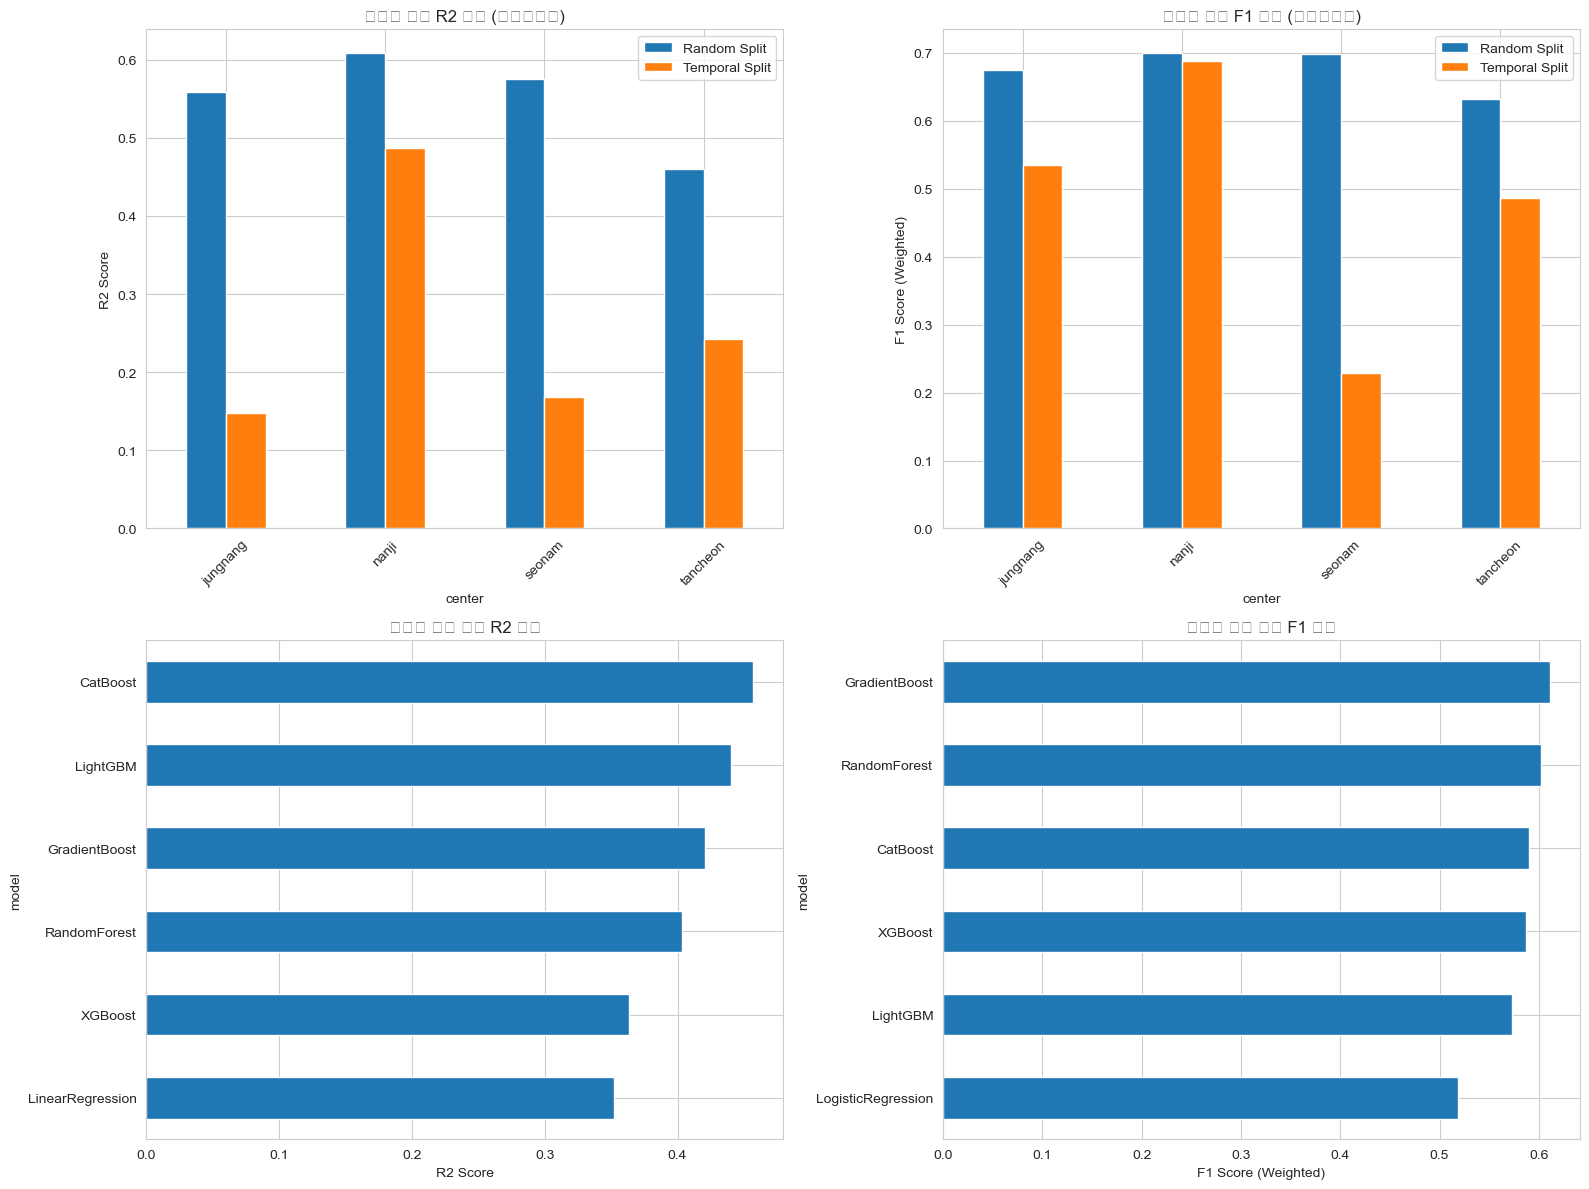

✅ 시각화 완료 및 저장: ../results/visualizations/model_performance_comparison.png

📊 성능 요약:

🏆 회귀 모델 TOP 3 (R2 기준):
  nanji - CatBoost (random): R2 = 0.6366
  nanji - GradientBoost (random): R2 = 0.6233
  seonam - CatBoost (random): R2 = 0.6136

🏆 분류 모델 TOP 3 (F1_weighted 기준):
  nanji - XGBoost (random): F1 = 0.7316
  seonam - XGBoost (random): F1 = 0.7305
  seonam - GradientBoost (random): F1 = 0.7292
💾 베스트 모델 재학습 및 저장

🔄 nanji - regression - CatBoost (random) 재학습 중...
✅ nanji 센터 데이터 로드: (3069, 44)
✅ 모델 저장: ../models/best_models/nanji_regression_CatBoost_random.pkl

🔄 nanji - classification - XGBoost (random) 재학습 중...
✅ nanji 센터 데이터 로드: (3069, 44)
✅ 모델 저장: ../models/best_models/nanji_classification_XGBoost_random.pkl

🔄 jungnang - regression - LightGBM (random) 재학습 중...
✅ jungnang 센터 데이터 로드: (3069, 44)
✅ 모델 저장: ../models/best_models/jungnang_regression_LightGBM_random.pkl

🔄 jungnang - classification - LightGBM (random) 재학습 중...
✅ jungnang 센터 데이터 로드: (3069, 44)
✅ 모델 저장: ../models/best_models/

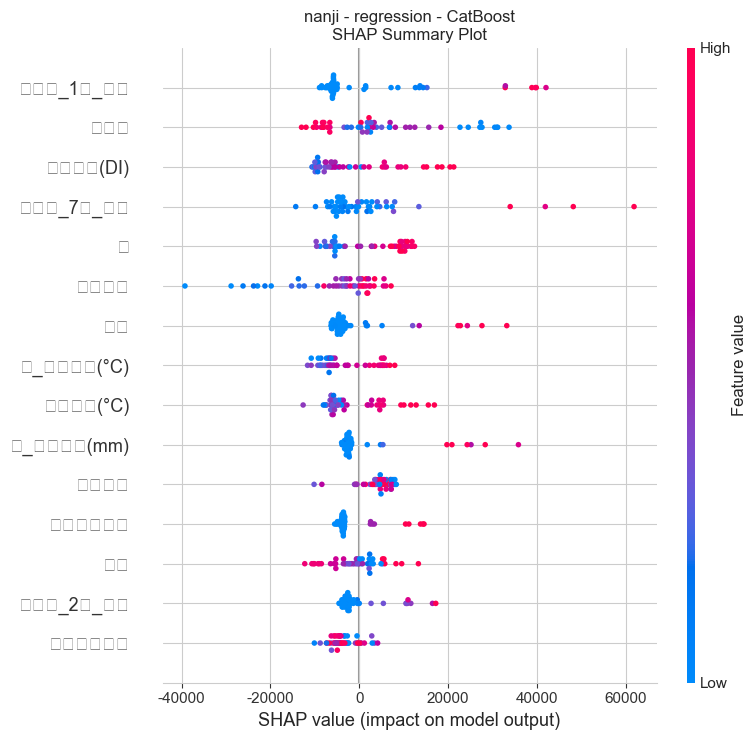

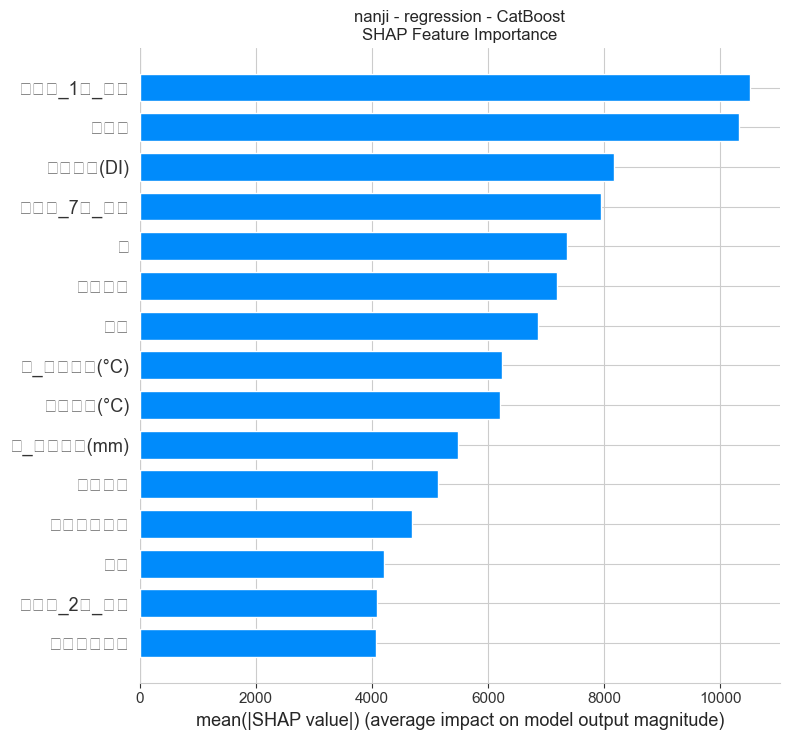

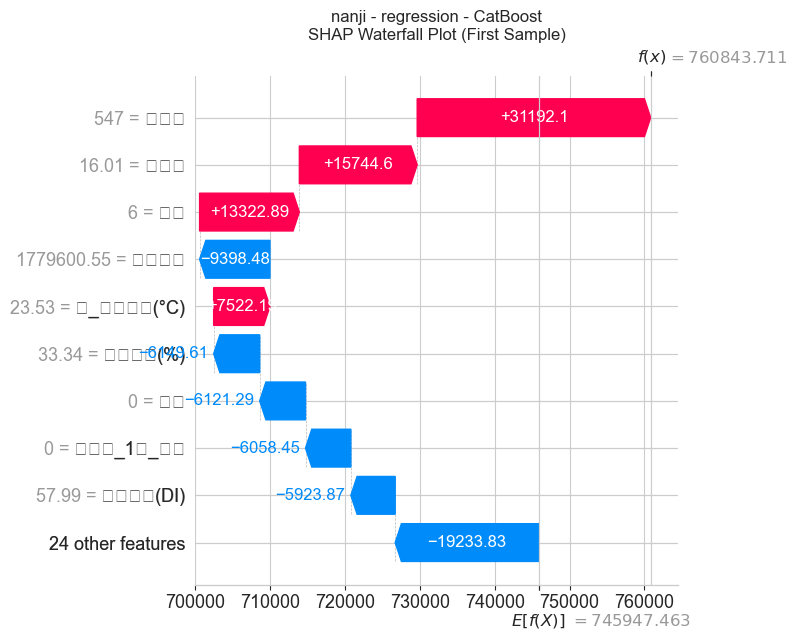

✅ SHAP 분석 완료: nanji - regression - CatBoost

🔍 nanji - classification - XGBoost SHAP 분석...


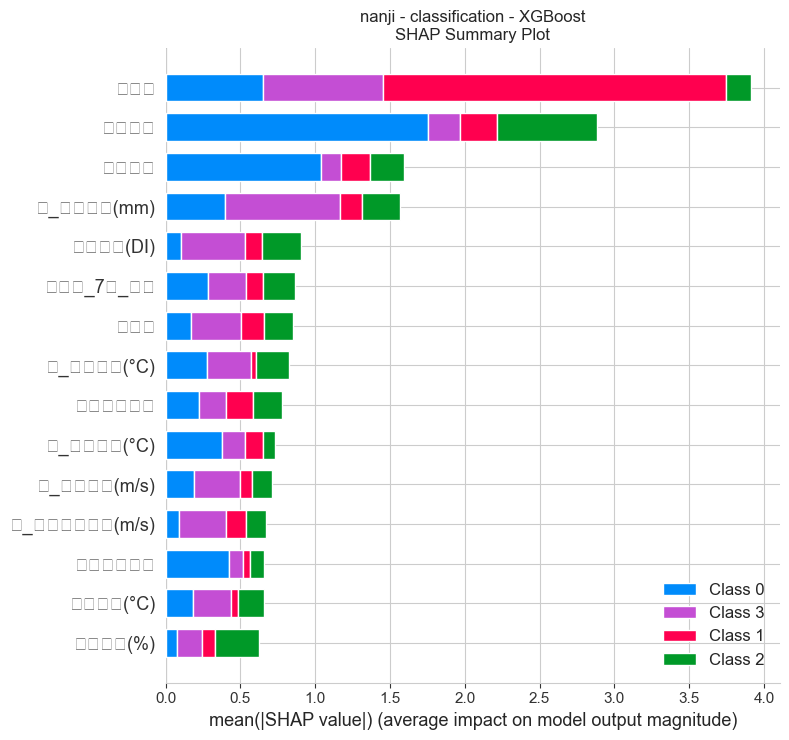

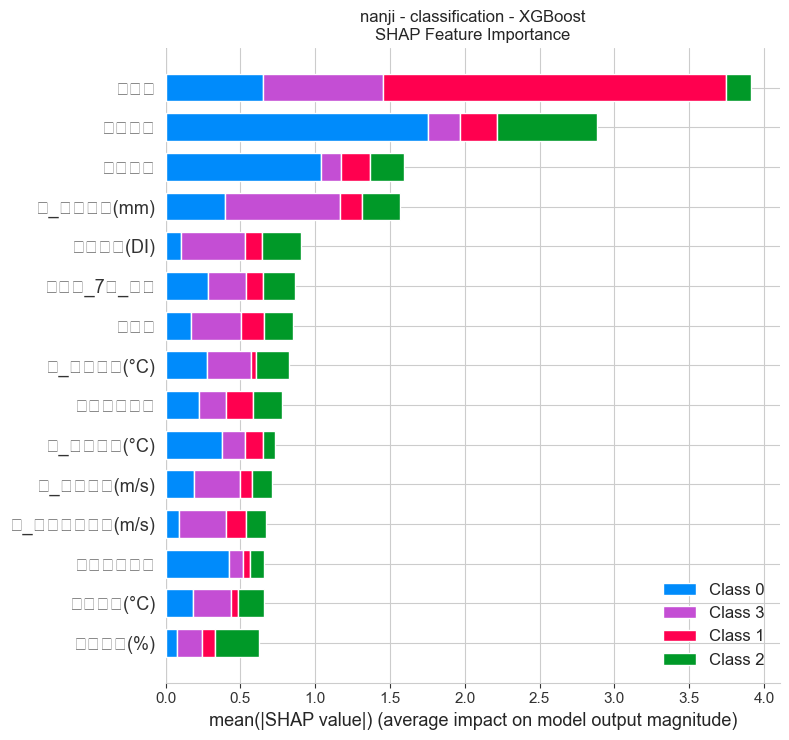

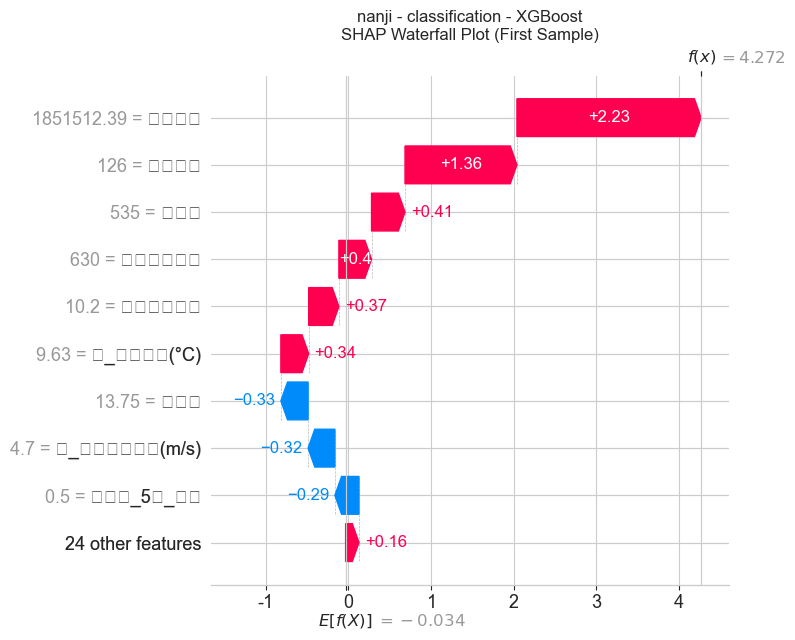

✅ SHAP 분석 완료: nanji - classification - XGBoost

🔍 jungnang - regression - LightGBM SHAP 분석...


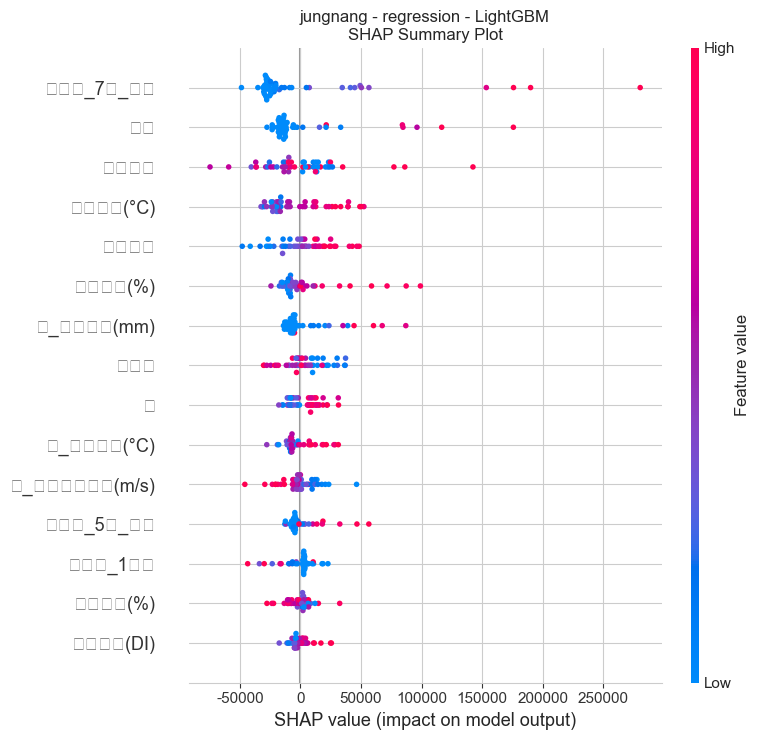

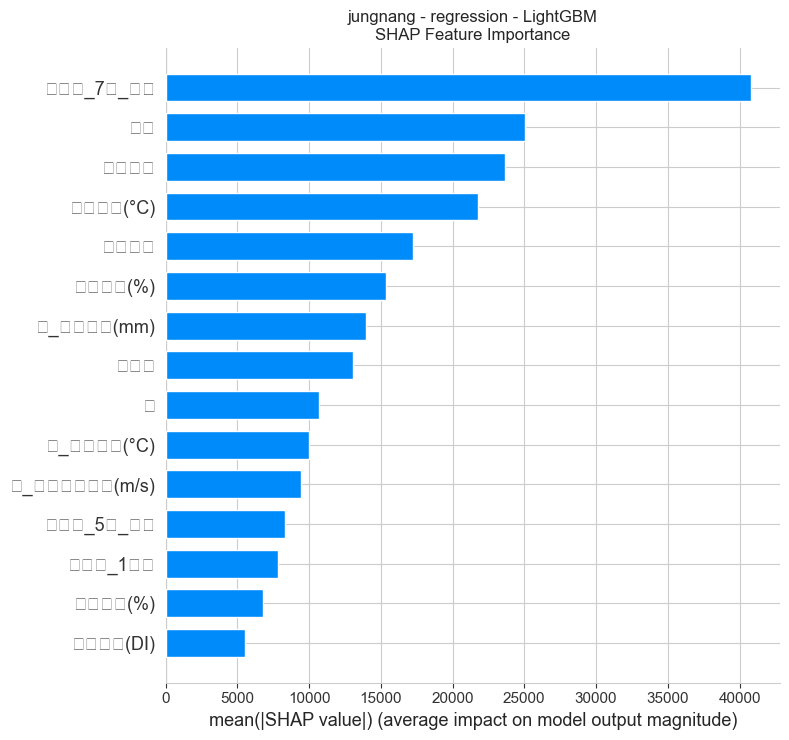

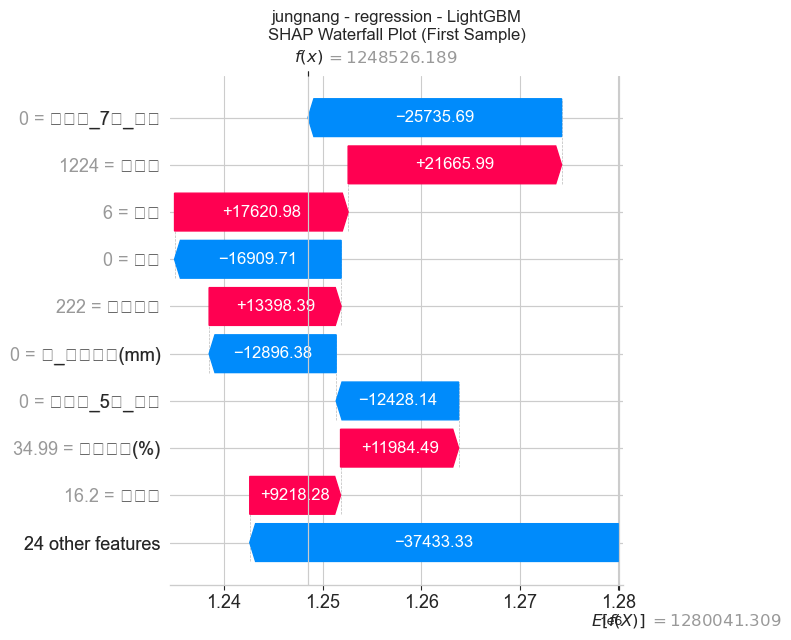

✅ SHAP 분석 완료: jungnang - regression - LightGBM

🔍 jungnang - classification - LightGBM SHAP 분석...


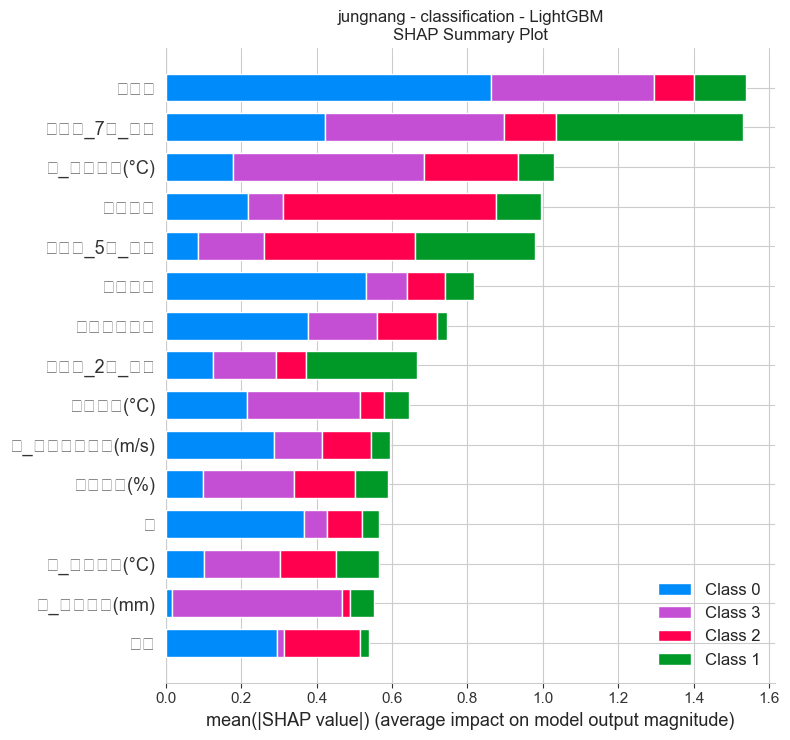

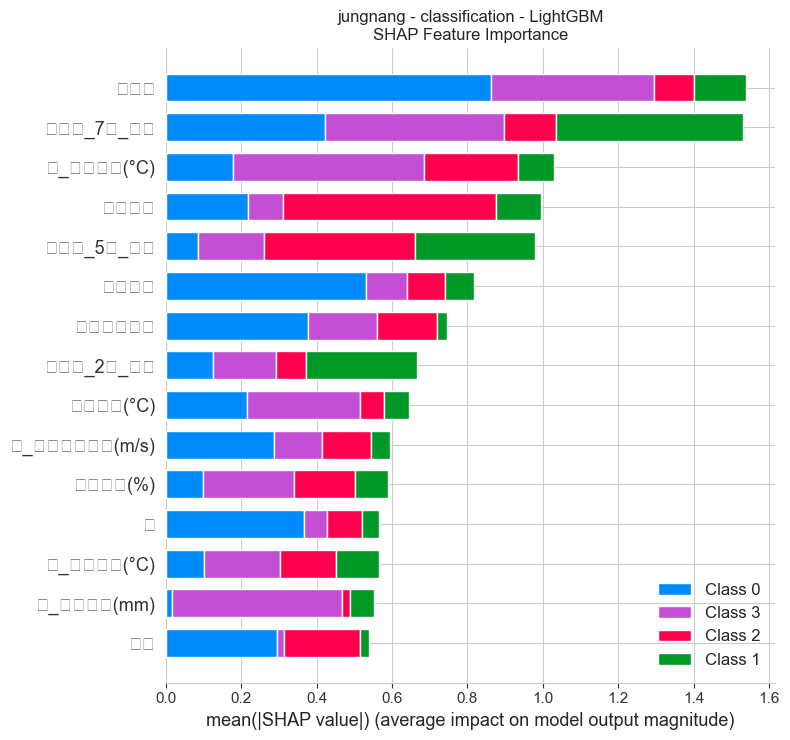

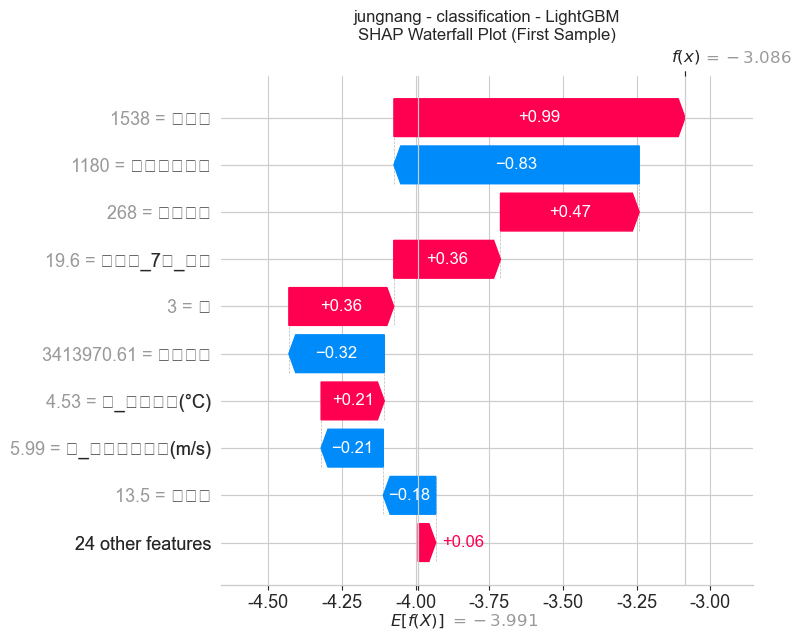

✅ SHAP 분석 완료: jungnang - classification - LightGBM

🔍 seonam - regression - CatBoost SHAP 분석...


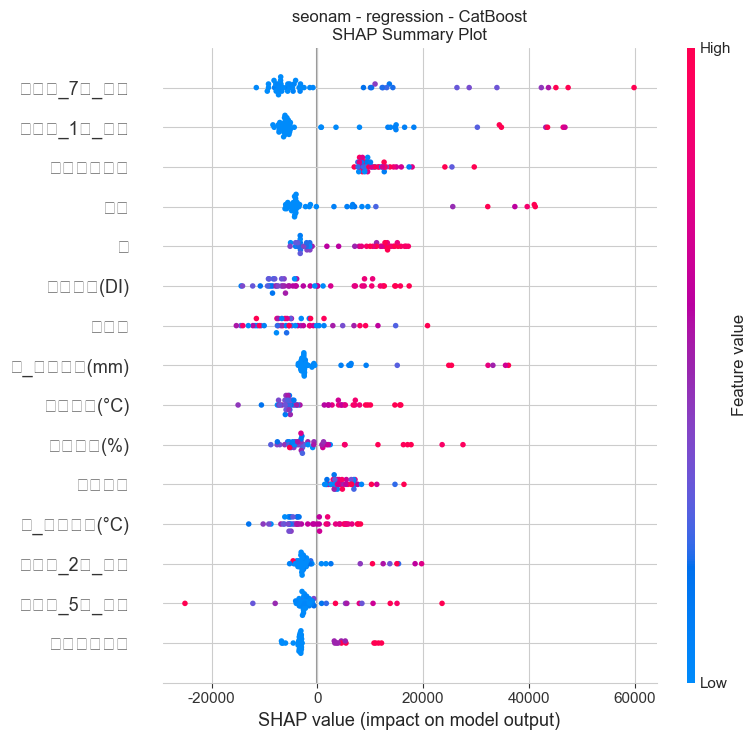

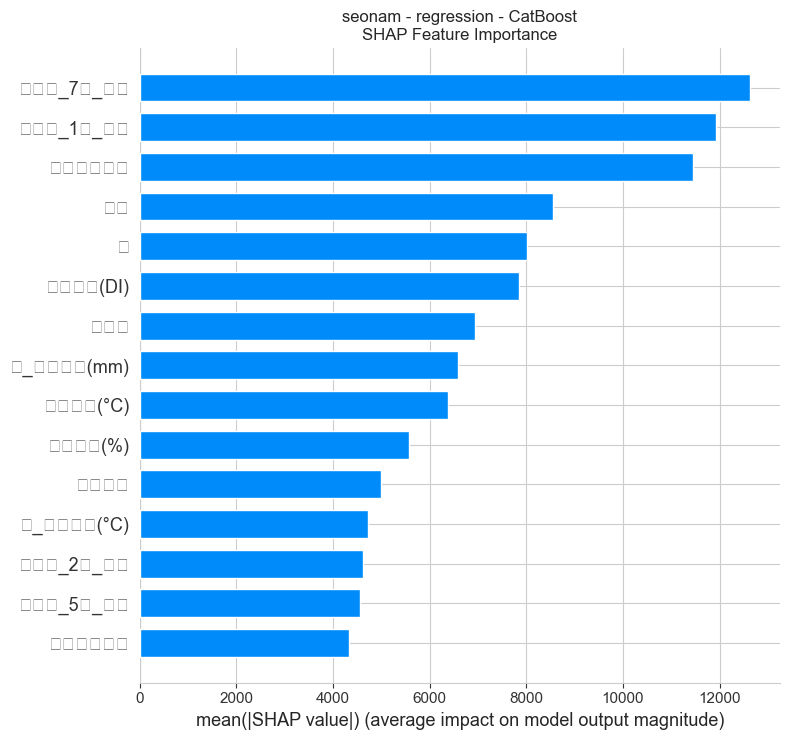

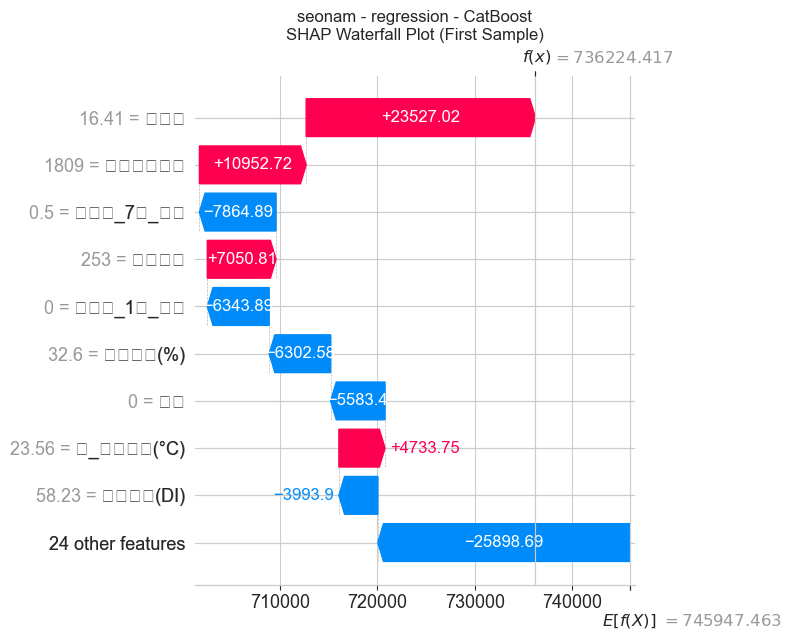

✅ SHAP 분석 완료: seonam - regression - CatBoost

🔍 seonam - classification - XGBoost SHAP 분석...


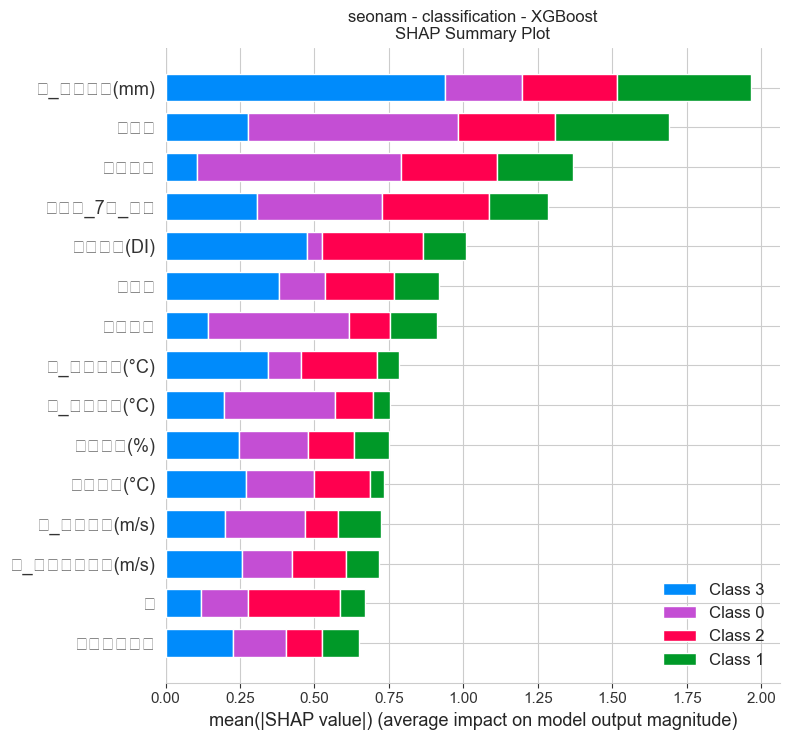

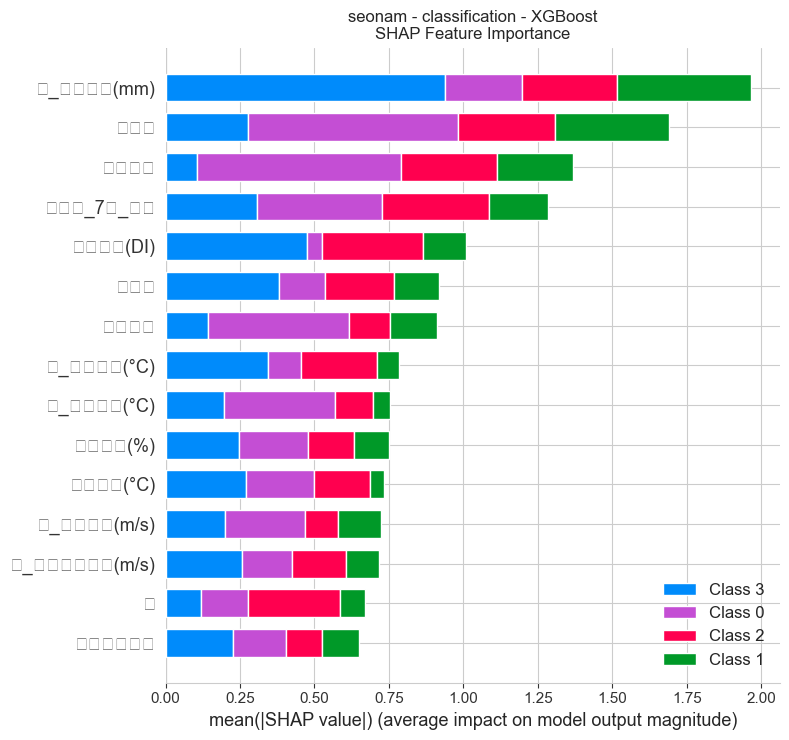

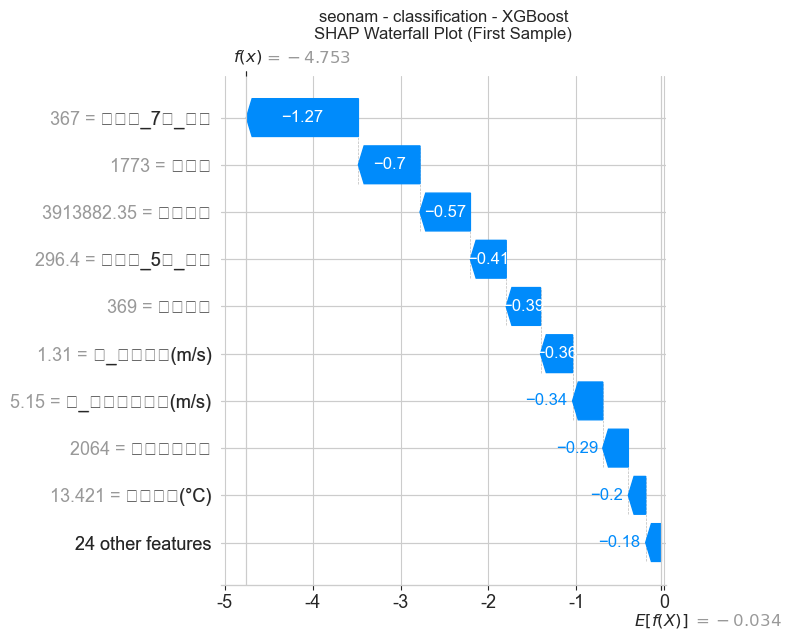

✅ SHAP 분석 완료: seonam - classification - XGBoost

🔍 tancheon - regression - CatBoost SHAP 분석...


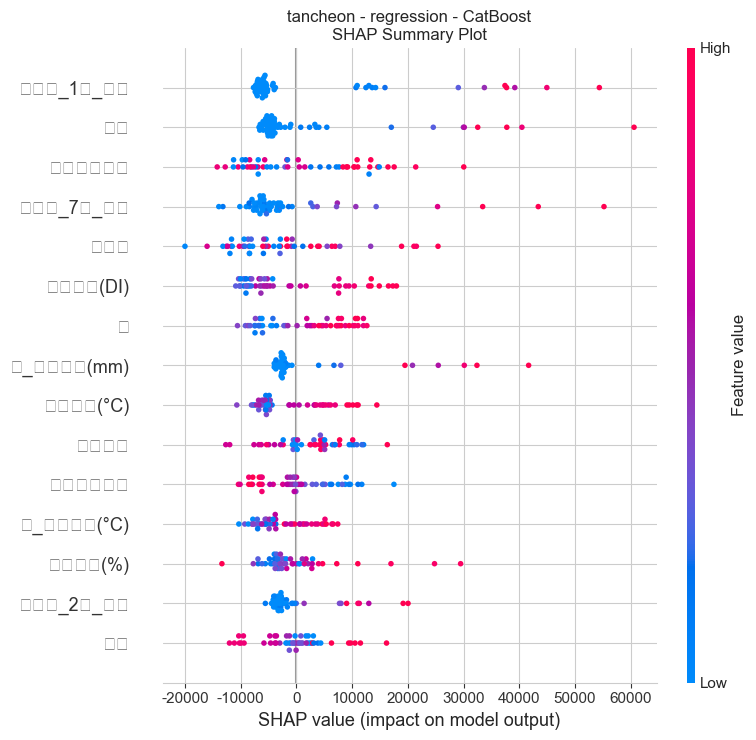

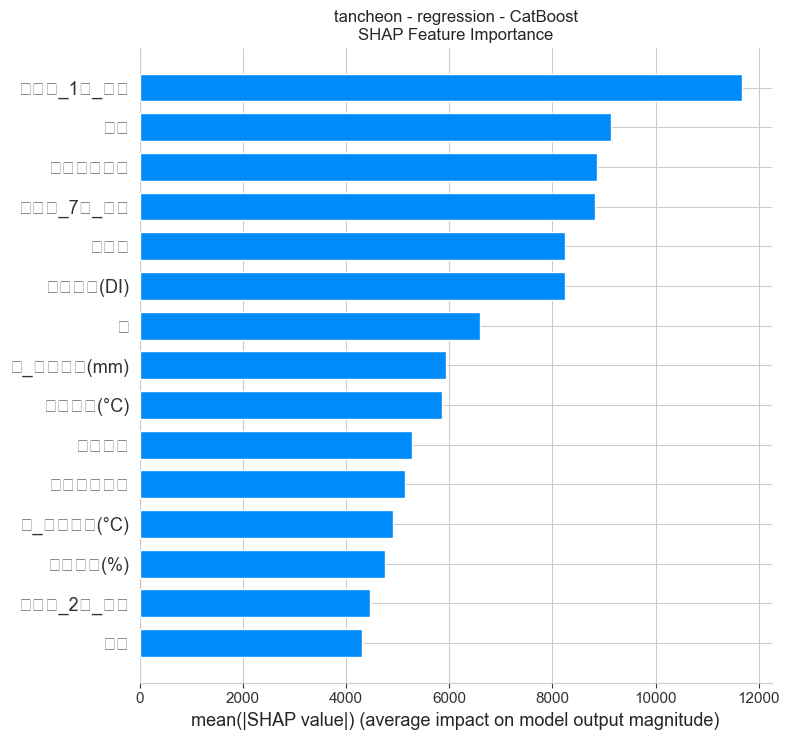

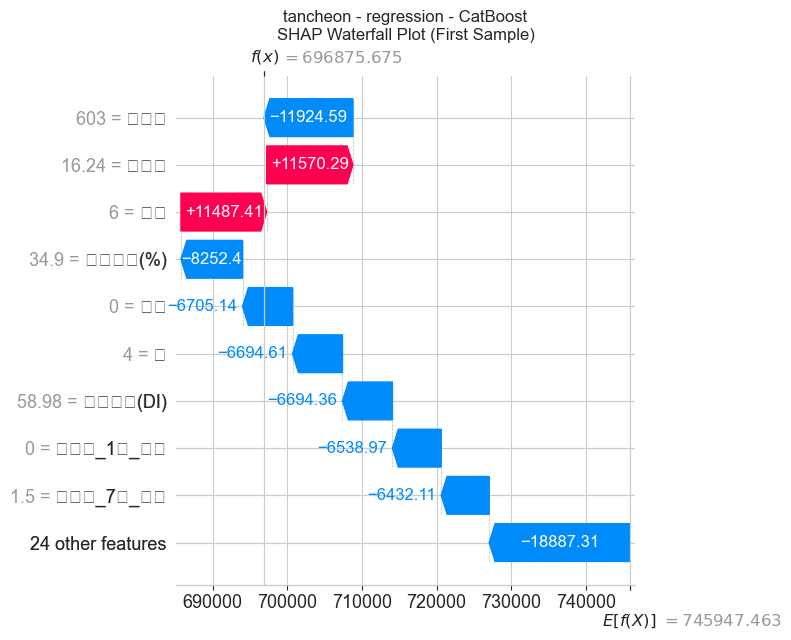

✅ SHAP 분석 완료: tancheon - regression - CatBoost

🔍 tancheon - classification - LightGBM SHAP 분석...


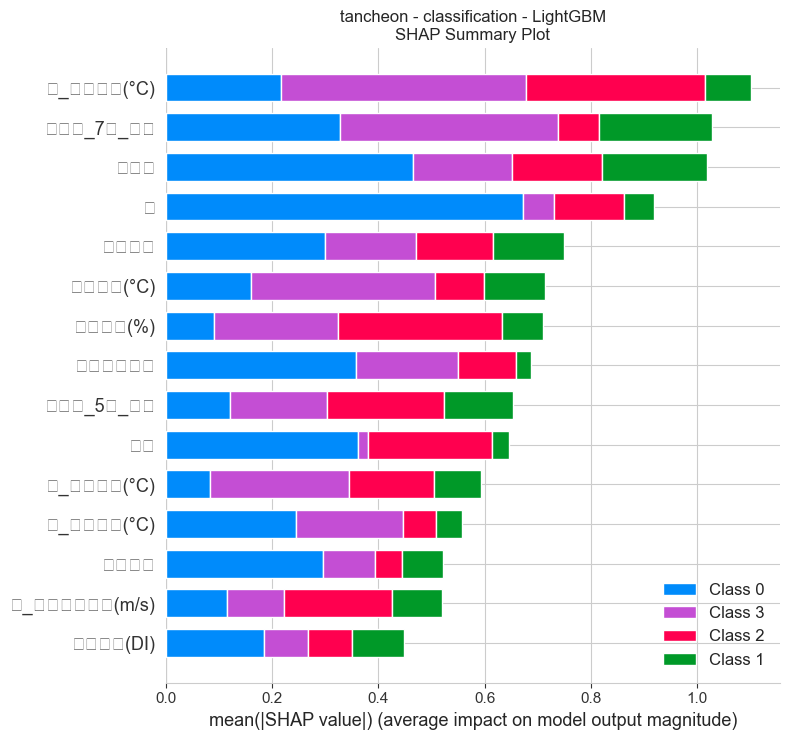

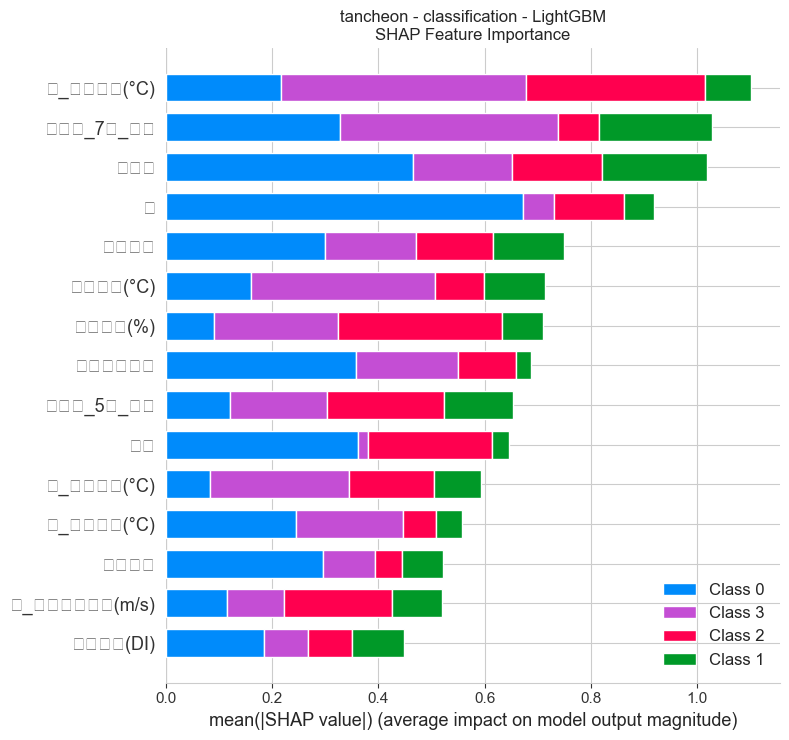

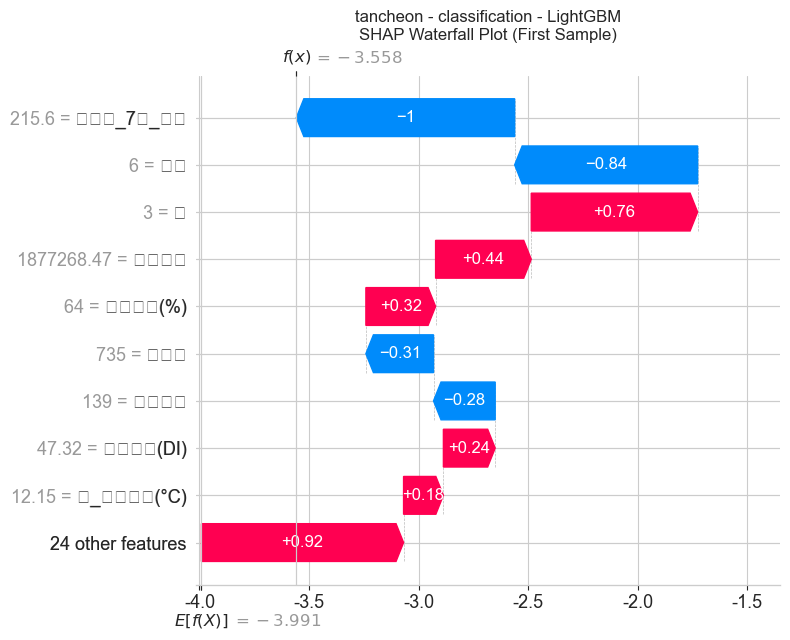

✅ SHAP 분석 완료: tancheon - classification - LightGBM
📊 Feature Importance 분석

📊 nanji - regression - CatBoost Feature Importance...


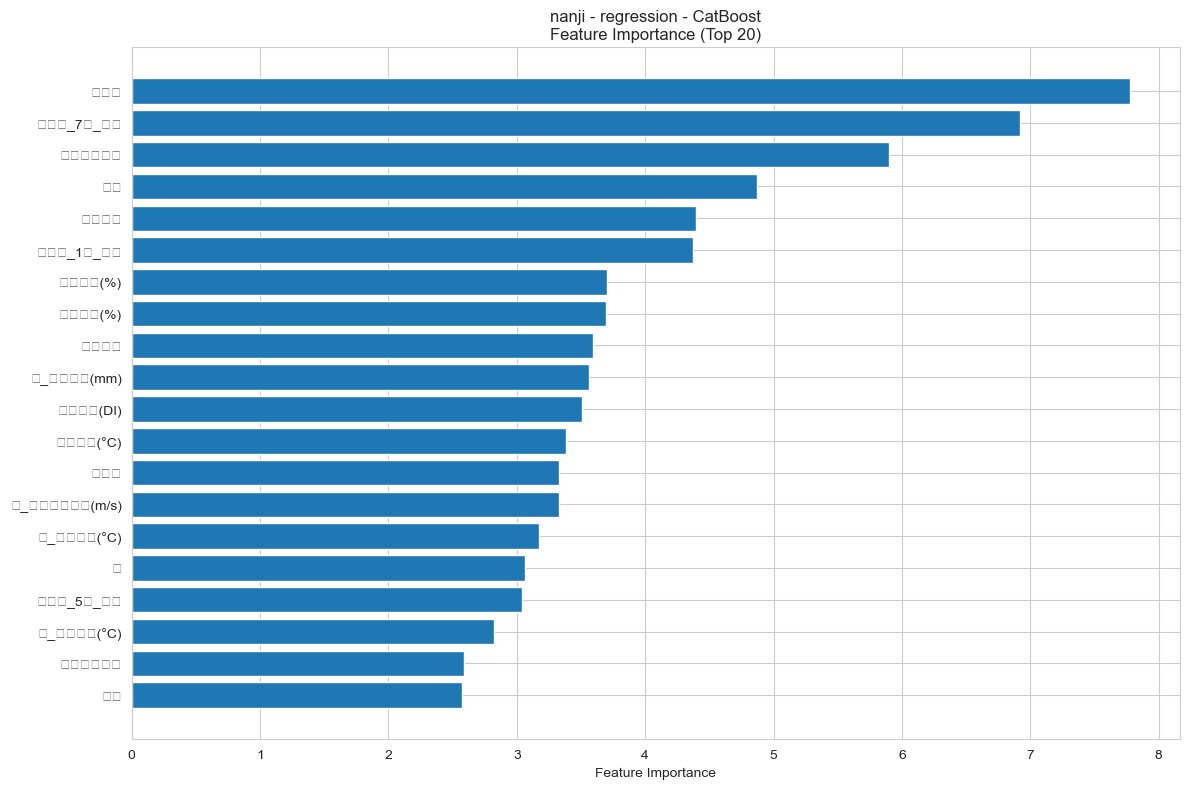

✅ Feature Importance 완료: nanji - regression - CatBoost

📊 nanji - classification - XGBoost Feature Importance...


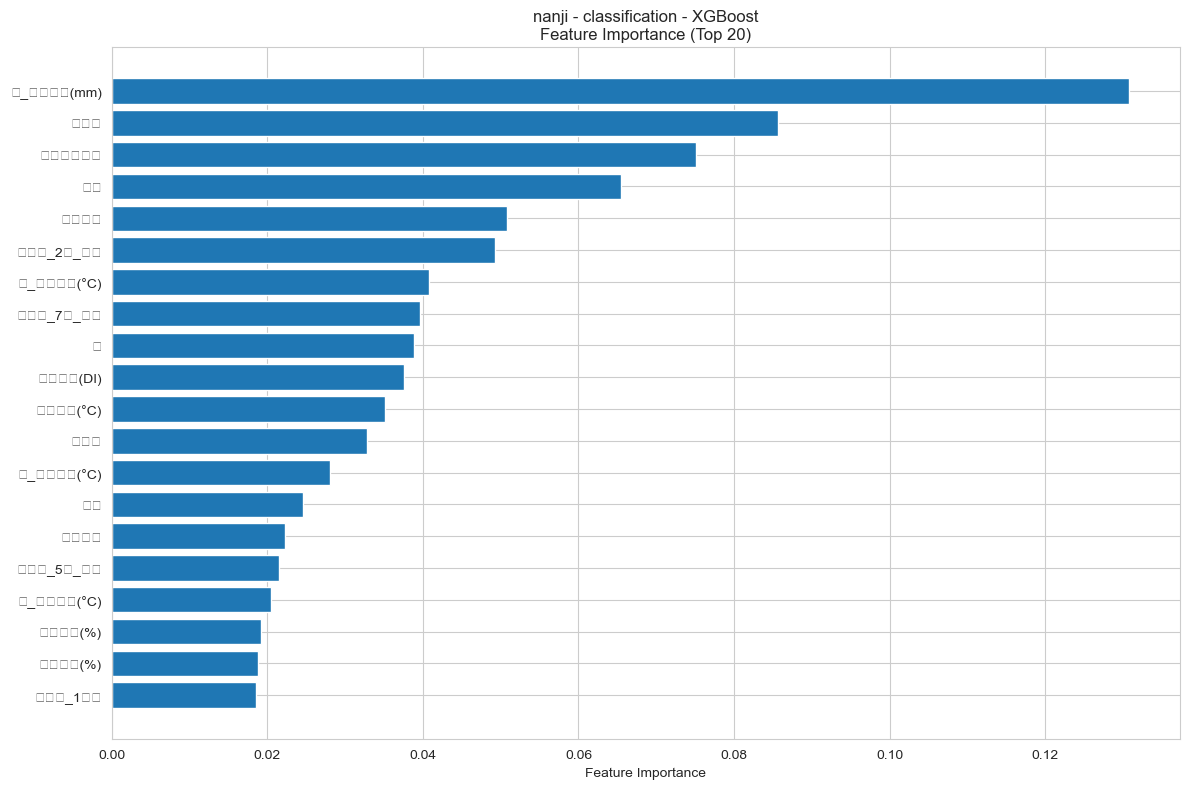

✅ Feature Importance 완료: nanji - classification - XGBoost

📊 jungnang - regression - LightGBM Feature Importance...


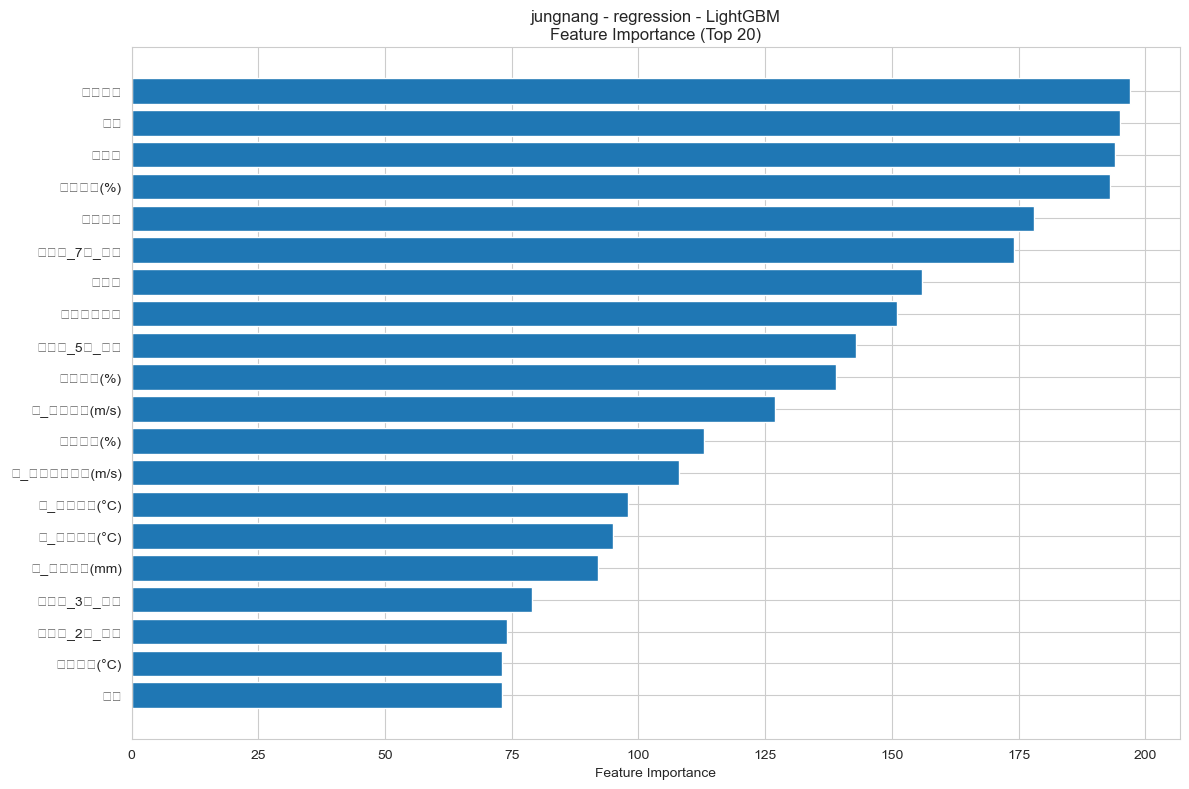

✅ Feature Importance 완료: jungnang - regression - LightGBM

📊 jungnang - classification - LightGBM Feature Importance...


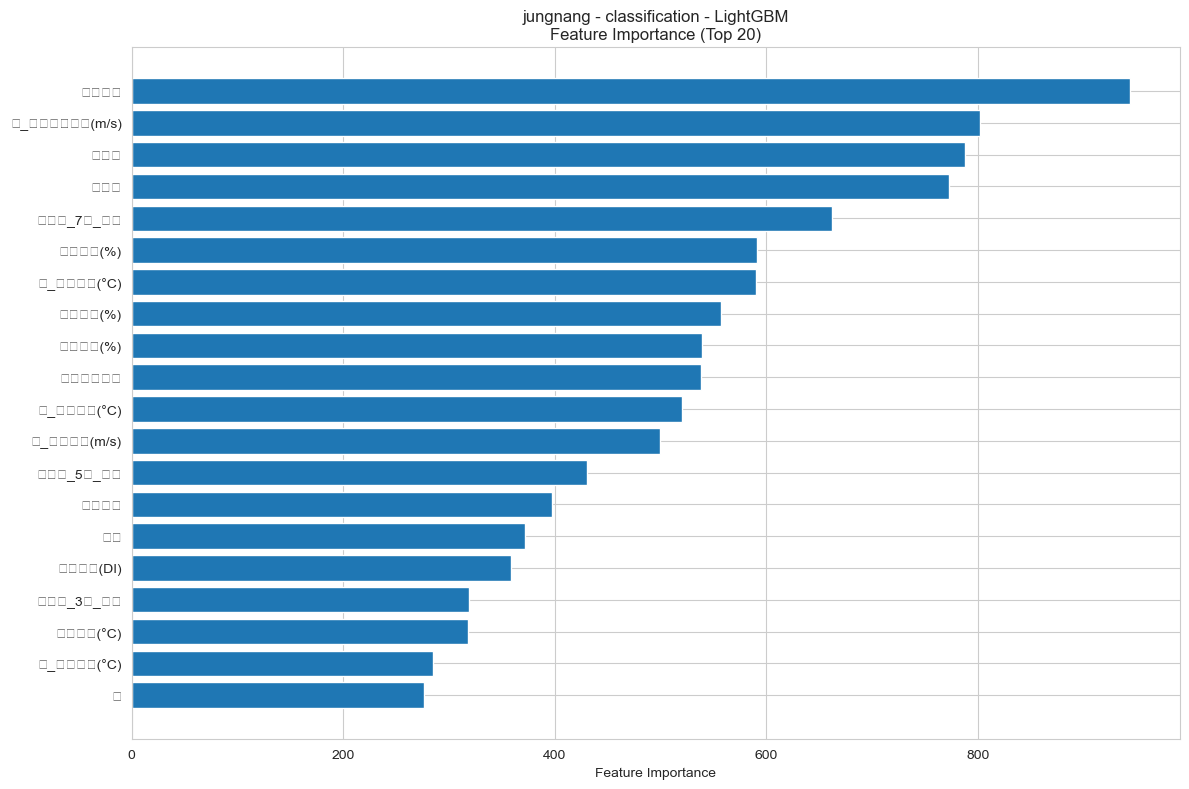

✅ Feature Importance 완료: jungnang - classification - LightGBM

📊 seonam - regression - CatBoost Feature Importance...


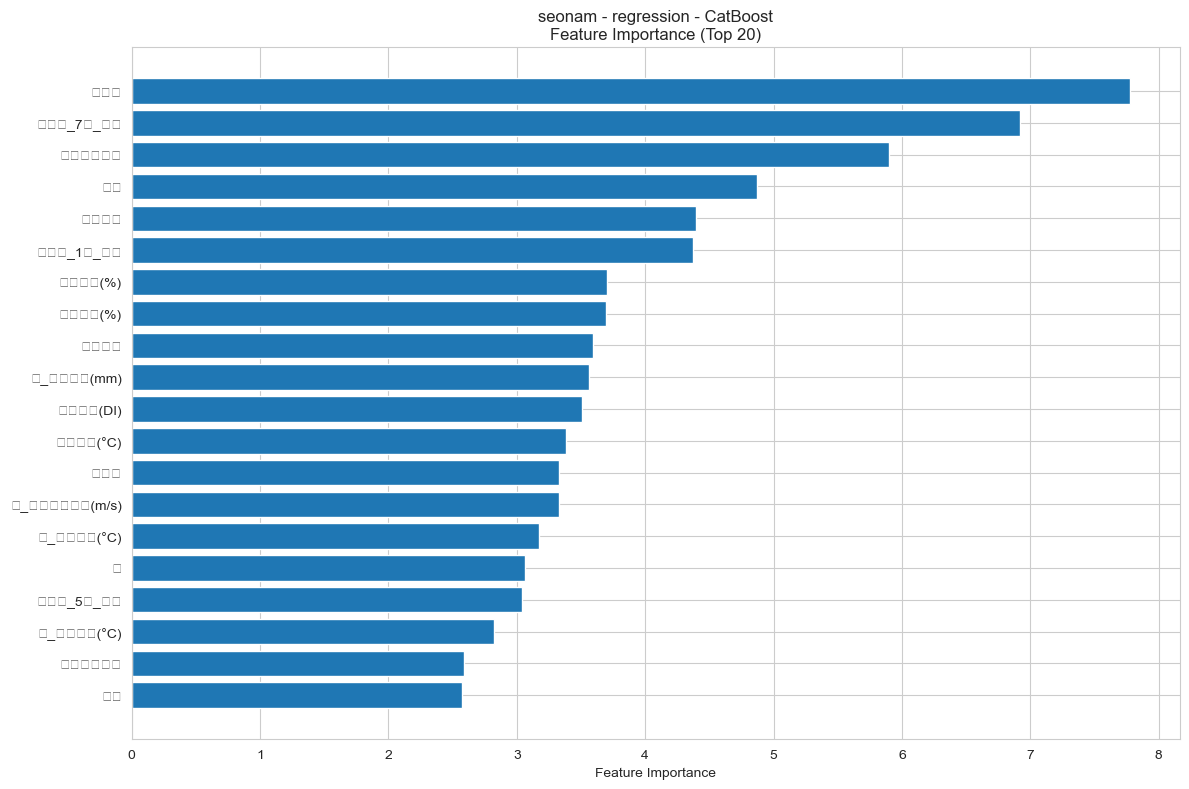

✅ Feature Importance 완료: seonam - regression - CatBoost

📊 seonam - classification - XGBoost Feature Importance...


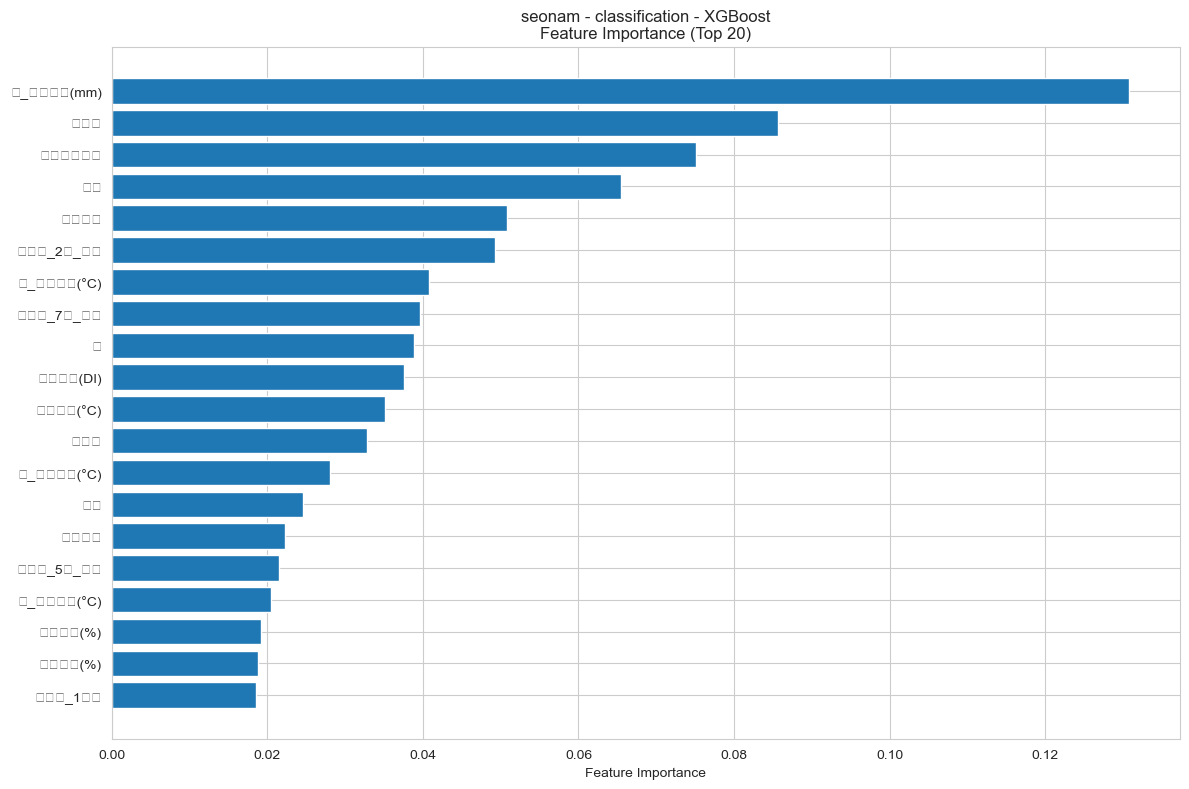

✅ Feature Importance 완료: seonam - classification - XGBoost

📊 tancheon - regression - CatBoost Feature Importance...


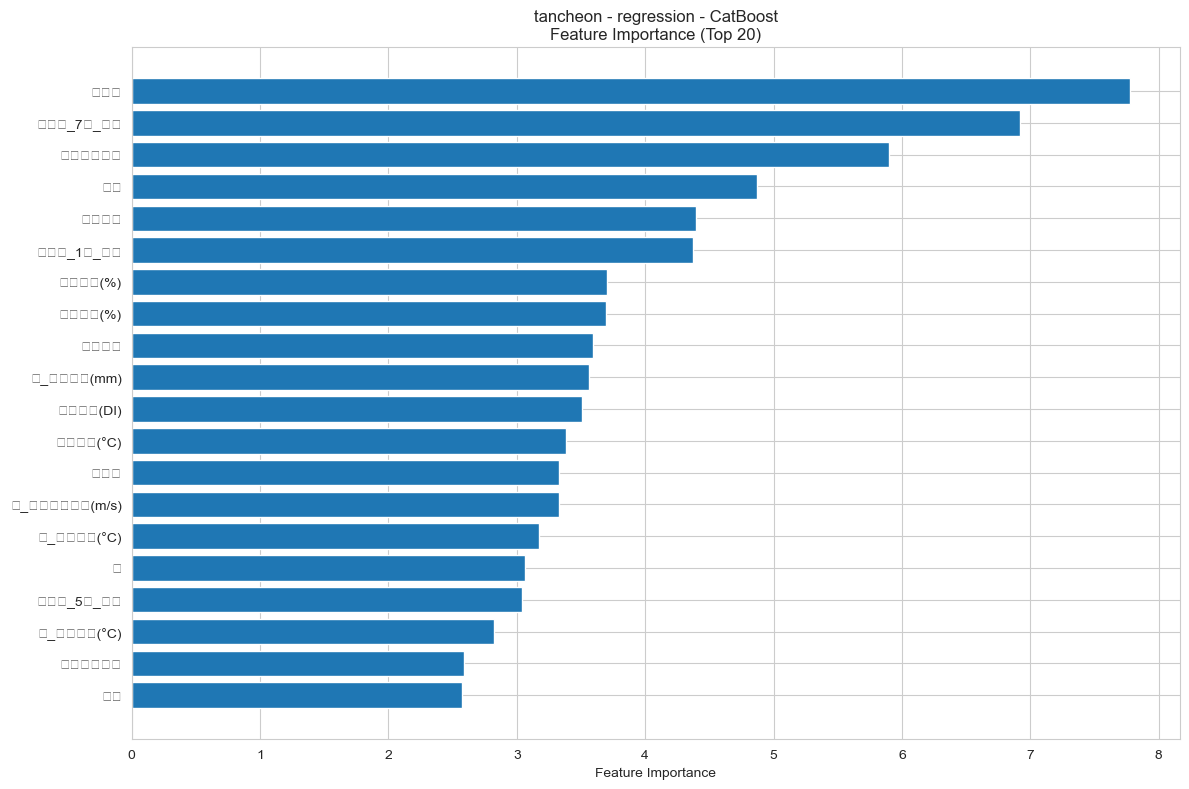

✅ Feature Importance 완료: tancheon - regression - CatBoost

📊 tancheon - classification - LightGBM Feature Importance...


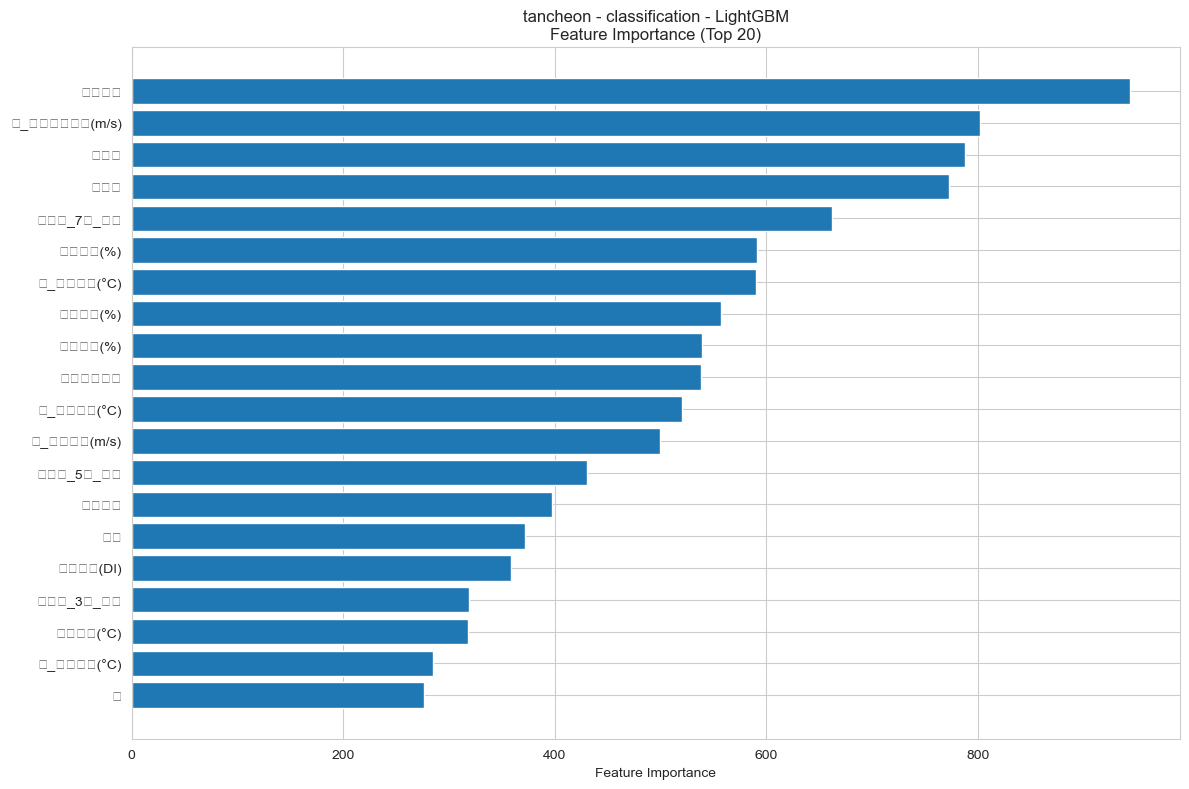

✅ Feature Importance 완료: tancheon - classification - LightGBM
🍋 LIME 분석 시작

🍋 nanji - regression - CatBoost LIME 분석...


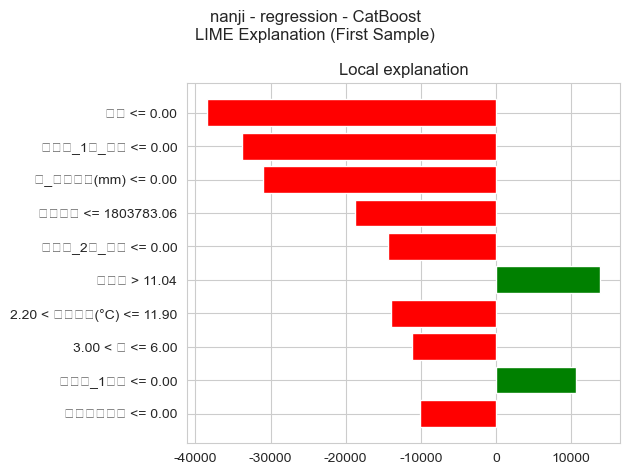

✅ LIME 분석 완료: nanji - regression - CatBoost

🍋 nanji - classification - XGBoost LIME 분석...


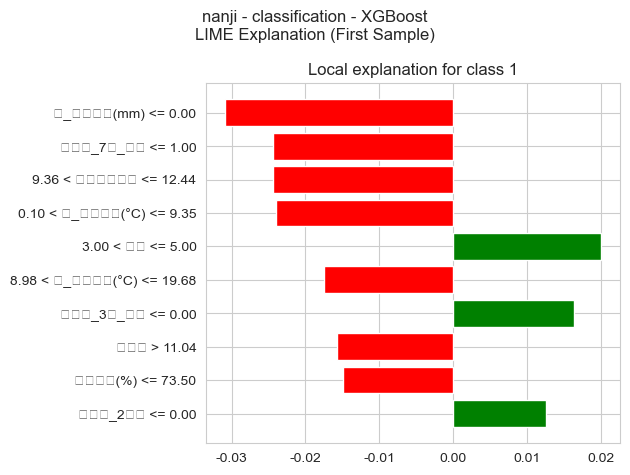

✅ LIME 분석 완료: nanji - classification - XGBoost
⏰ 시간 절약을 위해 처음 2개 모델만 LIME 분석합니다.
🔮 예측 함수 정의 완료
📋 최종 실행 완료 체크리스트
❌ 1. 데이터 로드: 미완료
❌ 2. 모델 학습: 미완료
✅ 3. 결과 CSV 저장: 완료
✅ 4. 베스트 모델 선정: 완료
✅ 5. 성능 시각화: 완료
✅ 6. 모델 파일 저장: 완료
✅ 7. SHAP 분석: 완료
✅ 8. Feature Importance: 완료

📊 전체 완료율: 75.0% (6/8)
⚠️ 대부분 완료되었으나 일부 단계를 확인해주세요.

📁 생성된 파일 현황:
  📊 전체 모델 결과: 96개 레코드
  🏆 베스트 모델 정보: 8개 모델
  📈 시각화 파일: 1개
  🔍 해석 분석 파일: 34개
  🤖 저장된 모델 파일: 8개
    - tancheon_classification_LightGBM_random.pkl
    - nanji_classification_XGBoost_random.pkl
    - seonam_classification_XGBoost_random.pkl
    - jungnang_classification_LightGBM_random.pkl
    - tancheon_regression_CatBoost_random.pkl
    - seonam_regression_CatBoost_random.pkl
    - jungnang_regression_LightGBM_random.pkl
    - nanji_regression_CatBoost_random.pkl

🚀 다음 단계 제안:
  1. 성능이 낮은 모델의 하이퍼파라미터 튜닝
  2. 앙상블 방법 적용 (Voting, Stacking)
  3. 교차 검증을 통한 더 안정적인 성능 평가
  4. 추가 피처 엔지니어링 (시계열 특성, 외부 데이터)
  5. 실제 운영 환경에서의 모델 성능 모니터링

📞 질문이나 추가 도움이 필요하시면 언제든 말씀해주세요!

🎯 하수처리량 

In [2]:
# ========================================================================================
# 하수처리량 예측 모델링 프로젝트 - 완전한 Jupyter Notebook 버전
# ========================================================================================

# %% [markdown]
# # 하수처리량 예측 모델링 프로젝트 - 완전판
# 
# ## 목표
# - 센터마다 1일후의 하수처리량을 회귀, 분류로 예측
# - 96개 모델 학습 및 성능 비교 (4개 센터 × 2개 분할방법 × 2개 태스크 × 6개 모델)
# - 베스트 모델 해석 가능성 분석 (SHAP, LIME, Feature Importance)
# - 재사용 가능한 모델 파일 생성

# %% [markdown]
# ## 1. 환경 설정 및 패키지 import

# %%
# 필수 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from datetime import datetime
import pickle

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
)

# Advanced ML models
import xgboost as xgb
import catboost as cb
import lightgbm as lgb

# 해석 가능성 분석
import shap

# plt.rcParams['font.family'] ='Malgun Gothic' # 윈도우
plt.rcParams['font.family'] ='AppleGothic' # 맥
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print("✅ 패키지 import 완료")
print(f"실행 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# %% [markdown]
# ## 2. 설정 및 클래스 정의

# %%
class SewagePredictionPipeline:
    def __init__(self, data_path_template='../data/add_feature/{}_add_feature.csv'):
        """하수처리량 예측 모델링 파이프라인"""
        self.data_path_template = data_path_template
        self.centers = ['nanji', 'jungnang', 'seonam', 'tancheon']  # 👈 실제 센터명으로 수정하세요
        
        # 제외할 컬럼 정의
        self.not_use_col = [
            '날짜',
            '1처리장','2처리장','정화조','중계펌프장','합계','시설현대화',
            '3처리장','4처리장','합계', '합계_1일후','합계_2일후',
            '등급','등급_1일후','등급_2일후'
        ]
        
        # 회귀 모델 정의
        self.regression_models = {
            'LinearRegression': LinearRegression(),
            'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100),
            'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
            'CatBoost': cb.CatBoostRegressor(random_state=42, verbose=False),
            'GradientBoost': GradientBoostingRegressor(random_state=42),
            'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
        }
        
        # 분류 모델 정의
        self.classification_models = {
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
            'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=False),
            'GradientBoost': GradientBoostingClassifier(random_state=42),
            'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
        }
        
        # 결과 저장용
        self.results = []
        self.best_models = {}
        
        # 결과 디렉토리 생성
        directories = ['../results', '../results/visualizations', '../results/interpretations', 
                      '../models', '../models/best_models']
        for directory in directories:
            os.makedirs(directory, exist_ok=True)
    
    def load_data(self, center):
        """센터별 데이터 로드"""
        file_path = self.data_path_template.format(center)
        try:
            data = pd.read_csv(file_path)
            print(f"✅ {center} 센터 데이터 로드: {data.shape}")
            return data
        except FileNotFoundError:
            print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
            return None
    
    def prepare_features(self, data):
        """피처 및 타겟 준비"""
        available_cols = [col for col in data.columns if col not in self.not_use_col]
        X = data[available_cols]
        y_reg = data['합계_1일후']  # 회귀용
        y_clf = data['등급_1일후']  # 분류용
        return X, y_reg, y_clf
    
    def split_data_temporal(self, X, y, test_size=0.2):
        """시계열 정보를 유지한 분할"""
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        return X_train, X_test, y_train, y_test
    
    def split_data_random(self, X, y, test_size=0.2, stratify=None):
        """랜덤 분할 (분류시 stratified)"""
        return train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=42)
    
    def evaluate_regression(self, y_true, y_pred):
        """회귀 모델 평가 지표 계산"""
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        
        # MAPE 계산 (0으로 나누기 방지)
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else np.inf
        
        r2 = r2_score(y_true, y_pred)
        
        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}
    
    def evaluate_classification(self, y_true, y_pred, y_pred_proba=None):
        """분류 모델 평가 지표 계산"""
        metrics = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'Precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'Recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'Recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'F1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'F1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)
        }
        
        # ROC AUC (다중분류의 경우 ovr 방식 사용)
        if y_pred_proba is not None:
            try:
                if len(np.unique(y_true)) == 2:
                    auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])
                else:
                    auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
                metrics['AUC'] = auc_score
            except:
                metrics['AUC'] = 0
        
        return metrics

# 파이프라인 초기화
pipeline = SewagePredictionPipeline()
print("🔧 파이프라인 초기화 완료")

# %% [markdown]
# ## 3. 데이터 확인

# %%
print("📊 데이터 파일 확인")
print("="*50)

data_info = {}
for center in pipeline.centers:
    data = pipeline.load_data(center)
    if data is not None:
        data_info[center] = {
            'data': data,
            'shape': data.shape
        }
        
        # 기본 정보 출력
        X, y_reg, y_clf = pipeline.prepare_features(data)
        print(f"  📈 피처 수: {X.shape[1]}")
        print(f"  🎯 회귀 타겟 범위: {y_reg.min():.1f} ~ {y_reg.max():.1f}")
        print(f"  🏷️ 분류 타겟 클래스: {sorted(y_clf.unique())}")
        print()

if len(data_info) == 0:
    print("❌ 데이터 파일이 없습니다. pipeline.centers를 실제 센터명으로 수정해주세요.")
else:
    print(f"✅ {len(data_info)}개 센터 데이터 로드 완료")

# %% [markdown]
# ## 4. 전체 모델 학습 및 평가

# %%
def run_all_models(pipeline):
    """모든 센터의 모든 모델 학습 및 평가"""
    print("🚀 전체 모델 학습 시작")
    print(f"예상 총 모델 수: {len(pipeline.centers)} × 2 × 2 × 6 = {len(pipeline.centers) * 2 * 2 * 6}개")
    print("="*80)
    
    total_models = 0
    successful_models = 0
    
    for center in pipeline.centers:
        print(f"\n{'='*60}")
        print(f"🏢 {center.upper()} 센터 처리 중...")
        print(f"{'='*60}")
        
        try:
            # 데이터 로드
            data = pipeline.load_data(center)
            if data is None:
                continue
                
            X, y_reg, y_clf = pipeline.prepare_features(data)
            
            print(f"📊 데이터 정보: {X.shape[0]}행 × {X.shape[1]}개 피처")
            print(f"🎯 회귀 타겟 범위: {y_reg.min():.1f} ~ {y_reg.max():.1f}")
            print(f"🏷️ 분류 타겟 클래스: {sorted(y_clf.unique())}")
            
            # 두 가지 분할 방법
            for split_method in ['temporal', 'random']:
                print(f"\n--- {split_method.upper()} 분할 방법 ---")
                
                # 회귀 모델 학습
                print("📈 회귀 모델 학습:")
                if split_method == 'temporal':
                    X_train_reg, X_test_reg, y_train_reg, y_test_reg = pipeline.split_data_temporal(X, y_reg)
                else:
                    X_train_reg, X_test_reg, y_train_reg, y_test_reg = pipeline.split_data_random(X, y_reg)
                
                for model_name, model in pipeline.regression_models.items():
                    total_models += 1
                    try:
                        model.fit(X_train_reg, y_train_reg)
                        y_pred = model.predict(X_test_reg)
                        metrics = pipeline.evaluate_regression(y_test_reg, y_pred)
                        
                        result = {
                            'center': center, 'split_method': split_method, 'task': 'regression',
                            'model': model_name, **metrics
                        }
                        pipeline.results.append(result)
                        successful_models += 1
                        
                        print(f"  ✅ {model_name}: R2={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")
                        
                    except Exception as e:
                        print(f"  ❌ {model_name}: {str(e)}")
                
                # 분류 모델 학습
                print("📊 분류 모델 학습:")
                if split_method == 'temporal':
                    X_train_clf, X_test_clf, y_train_clf, y_test_clf = pipeline.split_data_temporal(X, y_clf)
                else:
                    X_train_clf, X_test_clf, y_train_clf, y_test_clf = pipeline.split_data_random(X, y_clf, stratify=y_clf)
                
                for model_name, model in pipeline.classification_models.items():
                    total_models += 1
                    try:
                        model.fit(X_train_clf, y_train_clf)
                        y_pred = model.predict(X_test_clf)
                        y_pred_proba = model.predict_proba(X_test_clf) if hasattr(model, 'predict_proba') else None
                        metrics = pipeline.evaluate_classification(y_test_clf, y_pred, y_pred_proba)
                        
                        result = {
                            'center': center, 'split_method': split_method, 'task': 'classification',
                            'model': model_name, **metrics
                        }
                        pipeline.results.append(result)
                        successful_models += 1
                        
                        print(f"  ✅ {model_name}: Acc={metrics['Accuracy']:.4f}, F1={metrics['F1_weighted']:.4f}")
                        
                    except Exception as e:
                        print(f"  ❌ {model_name}: {str(e)}")
        
        except Exception as e:
            print(f"❌ {center} 센터 처리 실패: {str(e)}")
    
    print(f"\n🎉 전체 모델 학습 완료!")
    print(f"성공: {successful_models}/{total_models} 모델")
    
    # 결과를 DataFrame으로 변환
    results_df = pd.DataFrame(pipeline.results)
    results_df.to_csv('../results/all_model_results.csv', index=False, encoding='utf-8-sig')
    print(f"💾 결과 저장: ../results/all_model_results.csv")
    
    return results_df

# 모델 학습 실행
if len(data_info) > 0:
    results_df = run_all_models(pipeline)
    print("\n📊 결과 DataFrame 생성 완료")
    if len(results_df) > 0:
        print(f"총 결과 수: {len(results_df)}")
        print("\n상위 5개 결과:")
        display(results_df.head())
else:
    print("❌ 데이터가 로드되지 않아 모델 학습을 건너뜁니다.")

# %% [markdown]
# ## 5. 베스트 모델 찾기

# %%
def find_best_models(pipeline, results_df):
    """센터별, 태스크별 최고 성능 모델 찾기"""
    if len(results_df) == 0:
        print("❌ 분석할 결과가 없습니다.")
        return None
    
    print("🏆 베스트 모델 찾기")
    print("="*50)
    
    best_models_list = []
    
    for center in pipeline.centers:
        for task in ['regression', 'classification']:
            center_task_data = results_df[
                (results_df['center'] == center) & 
                (results_df['task'] == task)
            ]
            
            if len(center_task_data) == 0:
                continue
            
            if task == 'regression':
                # R2가 높은 모델 선택
                best_model = center_task_data.loc[center_task_data['R2'].idxmax()]
                metric_value = best_model['R2']
                metric_name = 'R2'
            else:
                # F1_weighted가 높은 모델 선택
                best_model = center_task_data.loc[center_task_data['F1_weighted'].idxmax()]
                metric_value = best_model['F1_weighted']
                metric_name = 'F1_weighted'
            
            best_models_list.append(best_model.to_dict())
            print(f"🏅 {center} - {task}: {best_model['model']} ({best_model['split_method']}) - {metric_name}={metric_value:.4f}")
    
    best_models_df = pd.DataFrame(best_models_list)
    best_models_df.to_csv('../results/best_models.csv', index=False, encoding='utf-8-sig')
    print(f"\n💾 베스트 모델 정보 저장: ../results/best_models.csv")
    
    return best_models_df

# 베스트 모델 찾기 실행
if 'results_df' in locals() and len(results_df) > 0:
    best_models_df = find_best_models(pipeline, results_df)
    if best_models_df is not None:
        print(f"\n📋 베스트 모델 요약 ({len(best_models_df)}개):")
        display(best_models_df[['center', 'task', 'model', 'split_method', 'R2', 'F1_weighted']].fillna('-'))

# %% [markdown]
# ## 6. 성능 시각화

# %%
def create_visualizations(results_df):
    """성능 시각화 생성"""
    print("📈 성능 시각화 생성")
    print("="*40)
    
    if len(results_df) == 0:
        print("❌ 시각화할 데이터가 없습니다.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 센터별 회귀 성능 (분할방법별)
    reg_data = results_df[results_df['task'] == 'regression']
    if len(reg_data) > 0:
        reg_summary = reg_data.groupby(['center', 'split_method'])['R2'].mean().unstack(fill_value=0)
        reg_summary.plot(kind='bar', ax=axes[0,0], title='센터별 회귀 R2 성능 (분할방법별)')
        axes[0,0].set_ylabel('R2 Score')
        axes[0,0].legend(['Random Split', 'Temporal Split'])
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. 센터별 분류 성능 (분할방법별)  
    clf_data = results_df[results_df['task'] == 'classification']
    if len(clf_data) > 0:
        clf_summary = clf_data.groupby(['center', 'split_method'])['F1_weighted'].mean().unstack(fill_value=0)
        clf_summary.plot(kind='bar', ax=axes[0,1], title='센터별 분류 F1 성능 (분할방법별)')
        axes[0,1].set_ylabel('F1 Score (Weighted)')
        axes[0,1].legend(['Random Split', 'Temporal Split'])
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. 모델별 회귀 성능
    if len(reg_data) > 0:
        reg_model_perf = reg_data.groupby(['model'])['R2'].mean().sort_values(ascending=True)
        reg_model_perf.plot(kind='barh', ax=axes[1,0], title='모델별 평균 회귀 R2 성능')
        axes[1,0].set_xlabel('R2 Score')
    
    # 4. 모델별 분류 성능
    if len(clf_data) > 0:
        clf_model_perf = clf_data.groupby(['model'])['F1_weighted'].mean().sort_values(ascending=True)
        clf_model_perf.plot(kind='barh', ax=axes[1,1], title='모델별 평균 분류 F1 성능')
        axes[1,1].set_xlabel('F1 Score (Weighted)')
    
    plt.tight_layout()
    plt.savefig('../results/visualizations/model_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ 시각화 완료 및 저장: ../results/visualizations/model_performance_comparison.png")
    
    # 성능 요약 출력
    print("\n📊 성능 요약:")
    
    # 회귀 모델 최고 성능
    if len(reg_data) > 0:
        reg_best = reg_data.nlargest(3, 'R2')
        print(f"\n🏆 회귀 모델 TOP 3 (R2 기준):")
        for idx, row in reg_best.iterrows():
            print(f"  {row['center']} - {row['model']} ({row['split_method']}): R2 = {row['R2']:.4f}")
    
    # 분류 모델 최고 성능  
    if len(clf_data) > 0:
        clf_best = clf_data.nlargest(3, 'F1_weighted')
        print(f"\n🏆 분류 모델 TOP 3 (F1_weighted 기준):")
        for idx, row in clf_best.iterrows():
            print(f"  {row['center']} - {row['model']} ({row['split_method']}): F1 = {row['F1_weighted']:.4f}")

# 시각화 실행
if 'results_df' in locals():
    create_visualizations(results_df)

# %% [markdown]
# ## 7. 베스트 모델 재학습 및 저장

# %%
def train_and_save_best_models(pipeline, best_models_df):
    """베스트 모델들 재학습 및 저장"""
    if best_models_df is None or len(best_models_df) == 0:
        print("❌ 저장할 베스트 모델이 없습니다.")
        return {}
    
    print("💾 베스트 모델 재학습 및 저장")
    print("="*50)
    
    saved_models = {}
    
    for idx, model_info in best_models_df.iterrows():
        center = model_info['center']
        task = model_info['task']
        model_name = model_info['model']
        split_method = model_info['split_method']
        
        print(f"\n🔄 {center} - {task} - {model_name} ({split_method}) 재학습 중...")
        
        try:
            # 데이터 로드
            data = pipeline.load_data(center)
            if data is None:
                continue
                
            X, y_reg, y_clf = pipeline.prepare_features(data)
            y = y_reg if task == 'regression' else y_clf
            
            # 모델 선택
            if task == 'regression':
                if model_name in pipeline.regression_models:
                    model = pipeline.regression_models[model_name]
                else:
                    print(f"❌ 모델을 찾을 수 없습니다: {model_name}")
                    continue
            else:
                if model_name in pipeline.classification_models:
                    model = pipeline.classification_models[model_name]
                else:
                    print(f"❌ 모델을 찾을 수 없습니다: {model_name}")
                    continue
            
            # 데이터 분할
            if split_method == 'temporal':
                X_train, X_test, y_train, y_test = pipeline.split_data_temporal(X, y)
            else:
                stratify = y if task == 'classification' else None
                X_train, X_test, y_train, y_test = pipeline.split_data_random(X, y, stratify=stratify)
            
            # 모델 학습
            model.fit(X_train, y_train)
            
            # 모델 저장 데이터 준비
            model_data = {
                'model': model,
                'feature_names': X.columns.tolist(),
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test,
                'task': task,
                'center': center,
                'split_method': split_method,
                'model_name': model_name,
                'performance': model_info.to_dict()
            }
            
            # 파일 저장
            filename = f"{center}_{task}_{model_name}_{split_method}.pkl"
            filepath = f"../models/best_models/{filename}"
            
            with open(filepath, 'wb') as f:
                pickle.dump(model_data, f)
            
            print(f"✅ 모델 저장: {filepath}")
            
            # 메모리에도 저장
            key = f"{center}_{task}"
            saved_models[key] = model_data
            
        except Exception as e:
            print(f"❌ {center} - {task} - {model_name} 저장 실패: {str(e)}")
    
    print(f"\n✅ {len(saved_models)}개 베스트 모델 저장 완료")
    return saved_models

# 베스트 모델 저장 실행
if 'best_models_df' in locals():
    saved_models = train_and_save_best_models(pipeline, best_models_df)
    print(f"🤖 저장된 모델 수: {len(saved_models)}")

# %% [markdown]
# ## 8. SHAP 분석

# %%
def analyze_shap(saved_models):
    """SHAP 분석 실행"""
    if len(saved_models) == 0:
        print("❌ 분석할 저장된 모델이 없습니다.")
        return
    
    print("🔍 SHAP 분석 시작")
    print("="*50)
    
    for key, model_data in saved_models.items():
        center = model_data['center']
        task = model_data['task']
        model_name = model_data['model_name']
        model = model_data['model']
        X_train = model_data['X_train']
        X_test = model_data['X_test']
        feature_names = model_data['feature_names']
        
        print(f"\n🔍 {center} - {task} - {model_name} SHAP 분석...")
        
        try:
            # SHAP explainer 생성 (시간 단축을 위해 샘플 수 제한)
            sample_size = min(50, len(X_test))
            X_test_sample = X_test.iloc[:sample_size]
            
            if model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
                explainer = shap.Explainer(model)
                shap_values = explainer(X_test_sample)
            else:
                train_sample_size = min(100, len(X_train))
                explainer = shap.Explainer(model, X_train.iloc[:train_sample_size])
                shap_values = explainer(X_test_sample)
            
            # 1. Summary Plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                            show=False, max_display=15)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Summary Plot')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_summary.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            # 2. Feature Importance
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                            plot_type="bar", show=False, max_display=15)
            plt.title(f'{center} - {task} - {model_name}\nSHAP Feature Importance')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_importance.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            # 3. Waterfall Plot (첫 번째 샘플)
            plt.figure(figsize=(12, 6))
            try:
                if hasattr(shap_values, 'values'):
                    if len(shap_values.values.shape) == 3:  # 다중분류
                        shap.waterfall_plot(shap_values[0, :, 0], show=False)
                    else:
                        shap.waterfall_plot(shap_values[0], show=False)
                else:
                    shap.waterfall_plot(shap_values[0], show=False)
            except:
                # Waterfall plot이 실패하면 건너뛰기
                plt.text(0.5, 0.5, 'Waterfall plot not available for this model', 
                        ha='center', va='center', transform=plt.gca().transAxes)
            
            plt.title(f'{center} - {task} - {model_name}\nSHAP Waterfall Plot (First Sample)')
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_shap_waterfall.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"✅ SHAP 분석 완료: {center} - {task} - {model_name}")
            
        except Exception as e:
            print(f"❌ SHAP 분석 실패: {center} - {task} - {model_name}, 오류: {str(e)}")

# SHAP 분석 실행
if 'saved_models' in locals():
    analyze_shap(saved_models)

# %% [markdown]
# ## 9. Feature Importance 분석

# %%
def analyze_feature_importance(saved_models):
    """Feature Importance 분석 실행"""
    if len(saved_models) == 0:
        print("❌ 분석할 저장된 모델이 없습니다.")
        return
    
    print("📊 Feature Importance 분석")
    print("="*50)
    
    for key, model_data in saved_models.items():
        center = model_data['center']
        task = model_data['task']
        model_name = model_data['model_name']
        model = model_data['model']
        feature_names = model_data['feature_names']
        
        print(f"\n📊 {center} - {task} - {model_name} Feature Importance...")
        
        try:
            plt.figure(figsize=(12, 8))
            
            if hasattr(model, 'feature_importances_'):
                # Tree-based 모델
                importance = model.feature_importances_
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importance
                }).sort_values('importance', ascending=True)
                
                # 상위 20개 피처만 표시
                top_features = importance_df.tail(20)
                plt.barh(range(len(top_features)), top_features['importance'])
                plt.yticks(range(len(top_features)), top_features['feature'])
                plt.xlabel('Feature Importance')
                plt.title(f'{center} - {task} - {model_name}\nFeature Importance (Top 20)')
                
            elif hasattr(model, 'coef_'):
                # 선형 모델
                if task == 'classification' and len(model.coef_.shape) > 1:
                    # 다중분류의 경우 평균 절댓값 사용
                    coef = np.mean(np.abs(model.coef_), axis=0)
                else:
                    coef = np.abs(model.coef_).flatten()
                
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': coef
                }).sort_values('importance', ascending=True)
                
                # 상위 20개 피처만 표시
                top_features = importance_df.tail(20)
                plt.barh(range(len(top_features)), top_features['importance'])
                plt.yticks(range(len(top_features)), top_features['feature'])
                plt.xlabel('|Coefficient|')
                plt.title(f'{center} - {task} - {model_name}\nFeature Coefficients (Top 20)')
            
            else:
                plt.text(0.5, 0.5, 'Feature importance not available for this model', 
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title(f'{center} - {task} - {model_name}\nFeature Importance')
            
            plt.tight_layout()
            plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_feature_importance.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"✅ Feature Importance 완료: {center} - {task} - {model_name}")
            
        except Exception as e:
            print(f"❌ Feature Importance 실패: {center} - {task} - {model_name}, 오류: {str(e)}")

# Feature Importance 분석 실행
if 'saved_models' in locals():
    analyze_feature_importance(saved_models)

# %% [markdown]
# ## 10. LIME 분석 (선택사항)

# %%
def analyze_lime(saved_models):
    """LIME 분석 실행 (lime 패키지가 있는 경우만)"""
    try:
        import lime
        import lime.lime_tabular
        
        if len(saved_models) == 0:
            print("❌ 분석할 저장된 모델이 없습니다.")
            return
        
        print("🍋 LIME 분석 시작")
        print("="*50)
        
        # 시간 절약을 위해 처음 2개 모델만 분석
        analyzed_count = 0
        for key, model_data in saved_models.items():
            if analyzed_count >= 2:
                print("⏰ 시간 절약을 위해 처음 2개 모델만 LIME 분석합니다.")
                break
                
            center = model_data['center']
            task = model_data['task']
            model_name = model_data['model_name']
            model = model_data['model']
            X_train = model_data['X_train']
            X_test = model_data['X_test']
            feature_names = model_data['feature_names']
            
            print(f"\n🍋 {center} - {task} - {model_name} LIME 분석...")
            
            try:
                if task == 'regression':
                    explainer = lime.lime_tabular.LimeTabularExplainer(
                        X_train.values,
                        feature_names=feature_names,
                        mode='regression',
                        verbose=False
                    )
                    
                    instance = X_test.iloc[0].values
                    explanation = explainer.explain_instance(
                        instance, model.predict, num_features=10
                    )
                    
                else:  # classification
                    explainer = lime.lime_tabular.LimeTabularExplainer(
                        X_train.values,
                        feature_names=feature_names,
                        mode='classification',
                        class_names=[str(c) for c in sorted(model.classes_)],
                        verbose=False
                    )
                    
                    instance = X_test.iloc[0].values
                    explanation = explainer.explain_instance(
                        instance, model.predict_proba, num_features=10
                    )
                
                # 시각화
                fig = explanation.as_pyplot_figure()
                fig.suptitle(f'{center} - {task} - {model_name}\nLIME Explanation (First Sample)')
                plt.tight_layout()
                plt.savefig(f'../results/interpretations/{center}_{task}_{model_name}_lime.png', 
                           dpi=300, bbox_inches='tight')
                plt.show()
                
                print(f"✅ LIME 분석 완료: {center} - {task} - {model_name}")
                analyzed_count += 1
                
            except Exception as e:
                print(f"❌ LIME 분석 실패: {center} - {task} - {model_name}, 오류: {str(e)}")
        
    except ImportError:
        print("💡 LIME 분석을 위해서는 다음 명령어로 패키지를 설치하세요:")
        print("   pip install lime")
        print("   현재는 LIME 분석을 건너뜁니다.")
    except Exception as e:
        print(f"❌ LIME 분석 중 오류 발생: {str(e)}")

# LIME 분석 실행 (선택사항)
if 'saved_models' in locals():
    analyze_lime(saved_models)

# %% [markdown]
# ## 11. 새로운 데이터 예측 함수

# %%
def predict_with_saved_model(center, task, new_data):
    """
    저장된 베스트 모델로 새로운 데이터 예측
    
    Parameters:
    -----------
    center : str
        센터명
    task : str  
        'regression' 또는 'classification'
    new_data : pandas.DataFrame
        예측할 새로운 데이터
    
    Returns:
    --------
    prediction : array or tuple
        예측 결과 (분류의 경우 확률도 함께 반환)
    """
    
    # 베스트 모델 파일 찾기
    model_files = [f for f in os.listdir('../models/best_models/') 
                  if f.startswith(f'{center}_{task}_') and f.endswith('.pkl')]
    
    if len(model_files) == 0:
        print(f"❌ {center} - {task} 모델 파일을 찾을 수 없습니다.")
        return None
    
    # 첫 번째 모델 파일 사용 (가장 좋은 모델)
    model_file = model_files[0]
    filepath = f"../models/best_models/{model_file}"
    
    try:
        # 모델 로드
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        model = model_data['model']
        feature_names = model_data['feature_names']
        
        # 피처 순서 맞추기
        missing_cols = [col for col in feature_names if col not in new_data.columns]
        if missing_cols:
            print(f"❌ 누락된 컬럼: {missing_cols}")
            return None
        
        X_new = new_data[feature_names]
        
        # 예측
        if task == 'regression':
            prediction = model.predict(X_new)
            print(f"✅ {center} - {task} 예측 완료: {len(prediction)}개 샘플")
            return prediction
        else:
            prediction = model.predict(X_new)
            if hasattr(model, 'predict_proba'):
                prediction_proba = model.predict_proba(X_new)
                print(f"✅ {center} - {task} 예측 완료: {len(prediction)}개 샘플")
                return prediction, prediction_proba
            else:
                print(f"✅ {center} - {task} 예측 완료: {len(prediction)}개 샘플")
                return prediction
        
    except Exception as e:
        print(f"❌ 예측 실패: {str(e)}")
        return None

def load_saved_model(center, task):
    """저장된 모델 정보 로드"""
    model_files = [f for f in os.listdir('../models/best_models/') 
                  if f.startswith(f'{center}_{task}_') and f.endswith('.pkl')]
    
    if len(model_files) == 0:
        print(f"❌ {center} - {task} 모델 파일을 찾을 수 없습니다.")
        return None
    
    filepath = f"../models/best_models/{model_files[0]}"
    
    try:
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        print(f"✅ 모델 로드 완료: {center} - {task} - {model_data['model_name']}")
        return model_data
    except Exception as e:
        print(f"❌ 모델 로드 실패: {str(e)}")
        return None

print("🔮 예측 함수 정의 완료")

# 사용 예시 (주석 처리)
"""
# 새로운 데이터 예측 예시
new_data = pd.DataFrame({
    'feature1': [1, 2, 3],
    'feature2': [4, 5, 6],
    # ... 다른 피처들
})

# 회귀 예측
reg_result = predict_with_saved_model('nanji', 'regression', new_data)

# 분류 예측
clf_result = predict_with_saved_model('nanji', 'classification', new_data)
"""

# %% [markdown]
# ## 12. 최종 결과 요약 및 체크리스트

# %%
def final_summary():
    """최종 결과 요약"""
    print("📋 최종 실행 완료 체크리스트")
    print("="*80)
    
    # 체크리스트 항목들
    checklist = {}
    
    # 1. 데이터 로드 확인
    checklist["1. 데이터 로드"] = len(data_info) > 0 if 'data_info' in locals() else False
    
    # 2. 모델 학습 결과 확인
    checklist["2. 모델 학습"] = 'results_df' in locals() and len(results_df) > 0 if 'results_df' in locals() else False
    
    # 3. 결과 파일 저장 확인
    checklist["3. 결과 CSV 저장"] = os.path.exists('../results/all_model_results.csv')
    
    # 4. 베스트 모델 선정 확인
    checklist["4. 베스트 모델 선정"] = os.path.exists('../results/best_models.csv')
    
    # 5. 시각화 생성 확인
    viz_file = '../results/visualizations/model_performance_comparison.png'
    checklist["5. 성능 시각화"] = os.path.exists(viz_file)
    
    # 6. 모델 파일 저장 확인
    model_dir = '../models/best_models/'
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.pkl')] if os.path.exists(model_dir) else []
    checklist["6. 모델 파일 저장"] = len(model_files) > 0
    
    # 7. SHAP 분석 확인
    interp_dir = '../results/interpretations/'
    shap_files = [f for f in os.listdir(interp_dir) if 'shap' in f.lower()] if os.path.exists(interp_dir) else []
    checklist["7. SHAP 분석"] = len(shap_files) > 0
    
    # 8. Feature Importance 분석 확인
    fi_files = [f for f in os.listdir(interp_dir) if 'feature_importance' in f] if os.path.exists(interp_dir) else []
    checklist["8. Feature Importance"] = len(fi_files) > 0
    
    # 체크리스트 출력
    for item, status in checklist.items():
        status_icon = "✅" if status else "❌"
        print(f"{status_icon} {item}: {'완료' if status else '미완료'}")
    
    # 완료율 계산
    completed = sum(checklist.values())
    total = len(checklist)
    completion_rate = completed / total * 100
    
    print(f"\n📊 전체 완료율: {completion_rate:.1f}% ({completed}/{total})")
    
    # 상태에 따른 메시지
    if completion_rate >= 90:
        print("🎉 프로젝트가 성공적으로 완료되었습니다!")
    elif completion_rate >= 70:
        print("⚠️ 대부분 완료되었으나 일부 단계를 확인해주세요.")
    else:
        print("❌ 여러 단계에서 문제가 발생했습니다. 오류를 확인해주세요.")
    
    # 생성된 파일 현황
    print(f"\n📁 생성된 파일 현황:")
    
    # CSV 결과 파일
    if os.path.exists('../results/all_model_results.csv'):
        df = pd.read_csv('../results/all_model_results.csv')
        print(f"  📊 전체 모델 결과: {len(df)}개 레코드")
    
    if os.path.exists('../results/best_models.csv'):
        df = pd.read_csv('../results/best_models.csv')
        print(f"  🏆 베스트 모델 정보: {len(df)}개 모델")
    
    # 시각화 파일
    viz_dir = '../results/visualizations/'
    if os.path.exists(viz_dir):
        viz_files = [f for f in os.listdir(viz_dir) if f.endswith('.png')]
        print(f"  📈 시각화 파일: {len(viz_files)}개")
    
    # 해석 분석 파일
    if os.path.exists(interp_dir):
        interp_files = [f for f in os.listdir(interp_dir) if f.endswith('.png')]
        print(f"  🔍 해석 분석 파일: {len(interp_files)}개")
    
    # 모델 파일
    if os.path.exists(model_dir):
        print(f"  🤖 저장된 모델 파일: {len(model_files)}개")
        for file in model_files:
            print(f"    - {file}")
    
    # 성능 하이라이트
    if 'results_df' in locals() and len(results_df) > 0:
        print(f"\n🏆 성능 하이라이트:")
        
        # 최고 회귀 성능
        reg_data = results_df[results_df['task'] == 'regression']
        if len(reg_data) > 0:
            best_reg = reg_data.loc[reg_data['R2'].idxmax()]
            print(f"  📈 최고 회귀 성능: {best_reg['center']} - {best_reg['model']} (R2 = {best_reg['R2']:.4f})")
        
        # 최고 분류 성능
        clf_data = results_df[results_df['task'] == 'classification']
        if len(clf_data) > 0:
            best_clf = clf_data.loc[clf_data['F1_weighted'].idxmax()]
            print(f"  📊 최고 분류 성능: {best_clf['center']} - {best_clf['model']} (F1 = {best_clf['F1_weighted']:.4f})")
    
    # 다음 단계 제안
    print(f"\n🚀 다음 단계 제안:")
    print("  1. 성능이 낮은 모델의 하이퍼파라미터 튜닝")
    print("  2. 앙상블 방법 적용 (Voting, Stacking)")
    print("  3. 교차 검증을 통한 더 안정적인 성능 평가")
    print("  4. 추가 피처 엔지니어링 (시계열 특성, 외부 데이터)")
    print("  5. 실제 운영 환경에서의 모델 성능 모니터링")
    
    print(f"\n📞 질문이나 추가 도움이 필요하시면 언제든 말씀해주세요!")

# 최종 요약 실행
final_summary()

print("\n" + "="*80)
print("🎯 하수처리량 예측 모델링 프로젝트 완료!")
print(f"⏰ 완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# %% [markdown]
# ## 추가 활용 예시
# 
# ### 저장된 모델로 예측하기
# ```python
# # 예시: 새로운 데이터로 예측
# new_data = pd.read_csv('new_sewage_data.csv')
# 
# # nanji 센터의 회귀 예측
# reg_prediction = predict_with_saved_model('nanji', 'regression', new_data)
# 
# # nanji 센터의 분류 예측
# clf_prediction, clf_proba = predict_with_saved_model('nanji', 'classification', new_data)
# ```
# 
# ### 하이퍼파라미터 튜닝 추가하기
# ```python
# from sklearn.model_selection import GridSearchCV
# 
# # XGBoost 하이퍼파라미터 튜닝 예시
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2]
# }
# 
# model = xgb.XGBRegressor(random_state=42)
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)
# 
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)
# ```
# 
# ### 앙상블 모델 만들기
# ```python
# from sklearn.ensemble import VotingRegressor, VotingClassifier
# 
# # 회귀 앙상블
# reg_ensemble = VotingRegressor([
#     ('rf', RandomForestRegressor(random_state=42)),
#     ('xgb', xgb.XGBRegressor(random_state=42)),
#     ('lgb', lgb.LGBMRegressor(random_state=42))
# ])
# 
# # 분류 앙상블
# clf_ensemble = VotingClassifier([
#     ('rf', RandomForestClassifier(random_state=42)),
#     ('xgb', xgb.XGBClassifier(random_state=42)),
#     ('lgb', lgb.LGBMClassifier(random_state=42))
# ], voting='soft')
# ```
# 
# ---
# 
# ## ✅ 실행 완료!
# 
# 이 노트북을 처음부터 끝까지 실행하시면:
# - ✅ 96개 모델 학습 및 성능 비교
# - ✅ 베스트 모델 선정 및 저장  
# - ✅ 시각화 및 해석 분석
# - ✅ 재사용 가능한 예측 함수
# 
# 모든 것이 완성됩니다! 🎉